# **Generalised SIAM URG**

In [ ]:
import itertools
from tqdm import tqdm
from time import sleep
from math import sqrt
from multiprocessing import Pool
from itertools import product, repeat
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
from qutip import *
from scipy.signal import peak_widths
from scipy.optimize import curve_fit
from functools import partial
import warnings
from scipy.sparse.linalg import eigsh
from scipy.linalg import eigh
import numpy.linalg
import os, sys
from scipy.signal import savgol_filter
from os import devnull

font = {'size'   : 40}

mpl.rc('font', **font)
mpl.rcParams['text.usetex'] = True
plt.rc('text.latex', preamble=r'\usepackage{amsmath,nicefrac,braket}')
plt.rcParams["figure.figsize"]= 10, 8
mpl.rcParams['lines.linewidth'] = 2
props = dict(boxstyle='round', ec='black', fc='white', alpha=0.5)

deltaD = 1
rho = 2/deltaD
nj = rho*deltaD

corr_folder = './corr_data/'
fig_folder = './figs/'
lfl_wf_folder = './wfs_for_entanglement/'

for folder in (corr_folder, fig_folder, lfl_wf_folder):
    if not os.path.exists(folder): os.mkdir(folder)

def qload(name):
    """
    Loads data file from file named 'filename.qu' in current directory.

    Parameters
    ----------
    name : str
        Name of data file to be loaded.

    Returns
    -------
    qobject : instance / array_like
        Object retrieved from requested file.

    """
    fileObject = open(name + '.qu', 'rb')  # open the file for reading
    out = pickle.load(fileObject)  # return the object from the file
    return out

## RG equations and denominators

Defines and evaluates denominators in the RG equations. The denominators in the RG equations are
$$
d_0 = \omega - \frac{D}{2} - \frac{U}{2} + \frac{K}{4}, \quad d_1 = \omega - \frac{D}{2} + \frac{U}{2} + \frac{J}{4}, \quad d_2 = \omega - \frac{D}{2} + \frac{J}{4}, \quad d_3 = \omega - \frac{D}{2} + \frac{K}{4}
$$

The RG equations for the symmetric spin-charge Anderson-Kondo are 
$$
\Delta U = 4V^2 n_j\left(\frac{1}{d_0} - \frac{1}{d_1}\right) - \frac{n_j}{2}\left(\frac{J^2}{d_2} - \frac{K^2}{d_3}\right),\\
\Delta V = -\frac{3n_j V}{8}\left[J\left(\frac{1}{d_2} + \frac{1}{d_1}\right) + K \left(\frac{1}{d_3} + \frac{1}{d_0}\right)\right],\\
\Delta J = -\frac{n_j J^2}{d_2}, \quad\quad\Delta K = -\frac{n_j K^2}{d_3}
$$

In [ ]:
def den(w, D, U, J, K, Ub=0):
    d0 = w - D/2 + Ub/4 - U/2 + K/4
    d1 = w - D/2 + Ub/4 + U/2 + J/4
    d2 = w - D/2 + Ub/4 + J/4
    d3 = w - D/2 + Ub/4 + K/4
    return np.array([d0, d1, d2, d3])

In [ ]:
def rg1(w, D, U, V, J, Ub=0):
    K = 0
    d0,d1,d2,d3 = den(w, D, U, J, K, Ub=Ub)
    deltaU = 4*V**2*nj*(1/d1 - 1/d0) - nj*J**2/(2*d2) if d1 < 0 else 0
    deltaV = -nj*(V/8)*((3*J + 4*Ub)*(1/d1 + 1/d2) + 4*Ub*(1/d0 + 1/d3)) if d1 < 0 else 0
    deltaJ = -nj*(J**2 + 4*J*Ub)/d2 if d2 < 0 else 0

    U = 0 if (U + deltaU) * U <= 0 else U + deltaU
    V = 0 if (V + deltaV) * V <= 0 else V + deltaV
    J = 0 if (J + deltaJ) * J <= 0 else J + deltaJ

    return U, V, J

def rg2(w, D, U, V, K):
    J = 0
    d0,d1,d2,d3 = den(w, D, U, J, K)
    deltaU = 4*V**2*nj*(1/d1 - 1/d0) + nj*K**2/(2*d3) if d0 < 0 else 0
    deltaV = -3*nj*V*K*(1/d0 + 1/d3)/8 if d0 < 0 else 0
    deltaK = -nj*K**2/d3

    U = 0 if (U + deltaU) * U <= 0 else U + deltaU
    V = 0 if (V + deltaV) * V <= 0 else V + deltaV
    K = 0 if (K + deltaK) * K <= 0 else K + deltaK

    return U, V, K

def rg3(w, D, U, V, J):
    K = 0
    d0,d1,d2,d3 = den(w, D, U, J, K)
    deltaU = 4*V**2*nj*(1/d1 - 1/d0) - nj*J**2/(2*d2)
    deltaV = -3*nj*V*J*(1/d1 + 1/d2)/8
    deltaJ = -nj*J**2/d2

    U = 0 if (U + deltaU) * U <= 0 else U + deltaU
    V = 0 if (V + deltaV) * V <= 0 else V + deltaV
    J = 0 if (J + deltaJ) * J <= 0 else J + deltaJ

    return U, V, J

## RG flow implementation

The following function does one complete RG for a given set of bare couplings and returns arrays of the flowing couplings.

In [ ]:
def complete_RG(w, D0, U0, V0, J0, Ub=0):
    d1 = den(w, D0, U0, J0, 0, Ub=Ub)[1]
    assert d1 < 0
    U = [U0]
    V = [V0]
    J = [J0]
    E = [D0]
    for D in np.arange(D0, 0, -deltaD):
        U_j, V_j, J_j = rg1(w, D, U[-1], V[-1], J[-1], Ub=Ub)
        U.append(U_j)
        V.append(V_j)
        J.append(J_j)
        E.append(D - deltaD)
        d0,d1,d2,d3 = den(w, E[-1], U[-1], J[-1], 0, Ub=Ub)
        if d1 >= 0 and d2 >= 0:
            break
        
    return np.array(E), np.array(U), np.array(V), np.array(J)

def complete_RG2(w, D0, U0, V0, K0):
    U = [U0]
    V = [V0]
    K = [K0]
    E = [D0]
    for D in np.arange(D0, 0, -deltaD):
        U_j, V_j, K_j = rg2(w, D, U[-1], V[-1], K[-1])
        U.append(U_j)
        V.append(V_j)
        K.append(K_j)
        E.append(D - deltaD)
        d0,d1,d2,d3 = den(w, E[-1], U[-1], 0, K[-1])
        if d3 >= 0:
            break
    return np.array(E), np.array(U), np.array(V), np.array(K)

def complete_RG3(w, D0, U0, V0, J0):
    U = [U0]
    V = [V0]
    J = [J0]
    E = [D0]
    for D in np.arange(D0, 0, -deltaD):
        U_j, V_j, J_j = rg3(w, D, U[-1], V[-1], J[-1])
        U.append(U_j)
        V.append(V_j)
        J.append(J_j)
        E.append(D - deltaD)
        d0,d1,d2,d3 = den(w, E[-1], U[-1], J[-1], 0)
        if d2 >= 0:
            break
        
    return np.array(E), np.array(U), np.array(V), np.array(J)

## Positive $U$ regime

In [ ]:
D0 = 50
w = -D0/2
U0 = D0/10
V0 = D0/100
J0 = D0/150
E, U, V, J = complete_RG(w, D0, U0, V0, J0)
steps = E/D0
txt = '\n'.join([r"$U_0/D_0 = {}$".format(U0/D0), r"$V_0/D_0 = {}$".format(V0/D0), r"$J_0/D_0 = {}$".format(J0/D0)])
plt.figure(figsize=(10,10))
plt.plot(steps, U/D0, 'red', lw=4, label=r'$J_0 > V_0$')
plt.xlabel(r"fraction of RG remaining")
plt.ylabel(r"$U/D_0$")
# plt.yscale("log")
# plt.text(0.5, 0.6, txt, bbox=props, size=35, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
# plt.savefig("U_irr,U>0,U.pdf", bbox_inches='tight')
# plt.show()
# plt.plot(steps, V/D0, 'red', lw=3)
# plt.xlabel(r"fraction of RG remaining")
# plt.ylabel(r"$V/D_0$")
# plt.yscale("log")
# plt.text(0.5, 0.6, txt, bbox=props, size=35, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
# plt.savefig("U_irr,U>0,V.pdf", bbox_inches='tight')
# plt.show()
# plt.plot(steps, J/D0, 'red', lw=3)
# plt.xlabel(r"fraction of RG remaining")
# plt.ylabel(r"$J/D_0$")
# plt.yscale("log")
# plt.text(0.5, 0.6, txt, bbox=props, size=35, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
# plt.savefig("U_irr,U>0,J.pdf", bbox_inches='tight')
# plt.show()
U0 = D0/10
V0 = D0/250
J0 = D0/150
E, U, V, J = complete_RG(w, D0, U0, V0, J0)
steps = E/D0
# txt = '\n'.join([r"$U_0/D_0 = {}$".format(U0/D0), r"$V_0/D_0 = {}$".format(V0/D0), r"$J_0/D_0 = {}$".format(J0/D0)])
twinax = plt.gca().twinx()
twinax.plot(steps, U/D0, 'b', lw=4, label=r'$J_0 < V_0$')
plt.plot([], [], 'red', lw=4, label=r'$J_0 > V_0$')
# plt.xlabel(r"fraction of RG remaining")
# plt.ylabel(r"$U/D_0$")
# plt.yscale("log")
# plt.text(0.5, 0.6, txt, bbox=props, size=35, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
# plt.savefig("U_rel,U>0,U.pdf", bbox_inches='tight')
# plt.show()
# plt.plot(steps, V/D0, 'red', lw=3)
# plt.xlabel(r"fraction of RG remaining")
# plt.ylabel(r"$V/D_0$")
# plt.yscale("log")
# plt.text(0.5, 0.6, txt, bbox=props, size=35, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
# plt.savefig("U_rel,U>0,V.pdf", bbox_inches='tight')
# plt.show()
# plt.plot(steps, J/D0, 'red', lw=3)
# plt.xlabel(r"fraction of RG remaining")
# plt.ylabel(r"$J/D_0$")
# plt.yscale("log")
# plt.text(0.5, 0.6, txt, bbox=props, size=35, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
# plt.savefig("U_rel,U>0,J.pdf", bbox_inches='tight')

plt.savefig("U_rel_irr.pdf", bbox_inches='tight')
plt.legend(loc=5)
plt.show()

In [ ]:
Drange = 10**np.linspace(1, 4, 6)
U0 = 0.1
V0 = 0.1
J0 = 0.05
plt.figure(figsize=(12,12))
for D0 in Drange:
    w = -D0/2
    E, U, V, J = complete_RG(w, D0, U0, V0, J0)
    plt.scatter(D0, V[-1], s=100, marker='o', color='r')
plt.xscale("log")
plt.yscale("log")
plt.ylabel(r"$V^*$")
plt.xlabel(r"$D_0$")
txt = '\n'.join([r"$\frac{{U_0}}{{V_0}} = {}$".format(U0/V0), r"$\frac{{J_0}}{{V_0}} = {}$".format(J0/V0)])
plt.text(0.75, 0.2, txt, bbox=props, size=40, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
plt.savefig("Vstar_vs_D_largeV.pdf", bbox_inches='tight')
plt.show()

V0 = 0.1
J0 = 0.25
plt.figure(figsize=(12,12))
for D0 in Drange:
    w = -D0/2
    E, U, V, J = complete_RG(w, D0, U0, V0, J0)
    plt.scatter(D0, V[-1], s=100, marker='o', color='r')
plt.xscale("log")
plt.yscale("log")
plt.ylabel(r"$V^*$")
plt.xlabel(r"$D_0$")
txt = '\n'.join([r"$\frac{{U_0}}{{V_0}} = {}$".format(U0/V0), r"$\frac{{J_0}}{{V_0}} = {}$".format(J0/V0)])
plt.text(0.75, 0.2, txt, bbox=props, size=40, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
plt.savefig("Vstar_vs_D_smallV.pdf", bbox_inches='tight')

## Phase map of relevance of $U$ in the $J-V$ plane

In [ ]:
def get_rel_V(J0):
    rel = []
    irr = []
    for V0 in J0_range:
        E, U, V, J = complete_RG(w, D0, U0, V0, J0)
        if U[-1] > U0:
            rel.append(V0/D0)
        else:
            if V0 == 1e-3:
                print ("Outlier:", J0/D0)
            irr.append(V0/D0)
    return rel, irr

D0 = 200
w = -D0/2
U0 = D0/10
J0_range = 10**np.linspace(-3, -1.5, 30)*D0
results = list(tqdm(Pool().imap(get_rel_V, J0_range), total=len(J0_range)))
for J0, (rel, irr) in zip(J0_range, results):
    plt.plot([J0]*len(rel), rel, color='r', lw=3)
    plt.plot([J0]*len(irr), irr, color='b', lw=3)
plt.plot([],[],color='r', label=r"$U$ relevant")
plt.plot([],[],color='b', label=r"$U$ irrelevant")
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$J_0$")
plt.ylabel(r"$V_0$")
plt.legend(loc=2)
plt.text(0.75, 0.2, r"$U_0/D_0 = {}$".format(U0/D0), bbox=props, size=35, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
plt.savefig("VvsJ_relvsirr.pdf", bbox_inches='tight')
plt.show()

## Phase map of $J^*/V^*$ in $J$ vs $V$

In [ ]:
def get_rel_JbyV(J0):
    rel = []
    irr = []
    for V0 in 10**np.linspace(-2.5, 0, 50)*J0:
        E, U, V, J = complete_RG(w, D0, U0, V0, J0)
        if J[-1] > V[-1]:
            rel.append(V0/D0)
        else:
            irr.append(V0/D0)
    return rel, irr

D0 = 10000
w = -D0/2
U0 = D0/10
J0_range = 10**np.linspace(-2.5, -1, 50)*D0
results = list(tqdm(Pool().imap(get_rel_JbyV, J0_range), total=len(J0_range)))
for J0, (rel, irr) in zip(J0_range, results):
    plt.plot([J0/D0]*len(rel), rel, color='r')
    plt.plot([J0/D0]*len(irr), irr, color='b')
plt.plot([],[],color='r', label=r"$J^* > V^*$")
plt.plot([],[],color='b', label=r"$J^* < V^*$")
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$J_0/D_0$")
plt.ylabel(r"$V_0/D_0$")
# plt.plot(J0_range/D0 + 0.5*10**(-3), J0_range/D0, ls='--')
plt.legend(loc=2)
plt.text(0.75, 0.2, r"$U_0/D_0 = {}$".format(U0/D0), bbox=props, size=35, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
# plt.savefig("VvsJ_relvsirr.pdf", bbox_inches='tight')
plt.show()

## Phase map of relevance of $U$ in the $J-U$ plane

In [ ]:
def get_rel_U(J0):
    rel = []
    irr = []
    for U0 in 10**np.linspace(-4, 3, 300):
        E, U, V, J = complete_RG(w, D0, U0, V0, J0)
        if U[-1] > U0:
            rel.append(U0/D0)
        else:
            if U0 == 1e-4:
                print ("Outlier:", J0/D0)
            irr.append(U0/D0)
    return rel, irr

D0 = 100
w = -D0/2
V0 = 0.1
J0_range = 10**np.linspace(-3, 1, 100)
results = list(tqdm(Pool(40).imap(get_rel_U, J0_range), total=len(J0_range)))
for J0, (rel, irr) in zip(J0_range, results):
    plt.plot([J0/D0]*len(rel), rel, color='r')
    plt.plot([J0/D0]*len(irr), irr, color='b')
plt.plot([],[],color='r', label=r"$U$ relevant")
plt.plot([],[],color='b', label=r"$U$ irrelevant")
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$J_0/D_0$")
plt.ylabel(r"$U_0/D_0$")
plt.legend(loc=2)
plt.text(0.75, 0.2, r"$V_0/D_0 = {}$".format(V0/D0), bbox=props, size=35, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
# plt.savefig("UvsJ_relvsirr.pdf", bbox_inches='tight')
plt.show()

## Critical $U$ at partition for given $J$ over range of $J$

In [ ]:
def get_Uc(J0):
    rel = []
    irr = []
    for U0 in 10**np.linspace(-6, 3, 200):
        E, U, V, J = complete_RG(w, D0, U0, V0, J0)
        if U[-1] > U0:
            continue
        else:
            return U0/D0

D0 = 100
w = -D0
V0 = 0.2
J0_range = 10**np.linspace(-3.5, 1, 100)
Uc = list(tqdm(Pool(40).imap(get_Uc, J0_range), total=len(J0_range)))
plt.scatter(J0_range/D0, Uc, color='black', marker='.')
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$J_0/D_0$")
plt.ylabel(r"$U_c/D_0$")
plt.text(0.75, 0.2, r"$V_0/D_0 = {}$".format(V0/D0), bbox=props, size=35, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
# plt.savefig("UcvsJ.pdf", bbox_inches='tight')
plt.show()

## Critical $V$ at partition for given $J$ over range of $J$

In [ ]:
def get_Vc(J0):
    rel = []
    irr = []
    for V0 in 10**np.linspace(-3, 1, 100):
        E, U, V, J = complete_RG(w, D0, U0, V0, J0)
        if U[-1] > U0:
            continue
        else:
            return V0/D0

D0 = 100
w = -D0
U0 = 1
J0_range = 10**np.linspace(-3, 1, 200)
Vc = list(tqdm(Pool(40).imap(get_Vc, J0_range), total=len(J0_range)))
plt.scatter(J0_range/D0, Vc, color='black', marker='.')
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$J_0/D_0$")
plt.ylabel(r"$V_c/D_0$")
plt.text(0.75, 0.2, r"$U_0/D_0 = {}$".format(U0/D0), bbox=props, size=35, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
# plt.savefig("VcvsJ.pdf", bbox_inches='tight')
plt.show()

## Critical $J$ at partition for given $V$ over range of $V$

In [ ]:
def get_Jc(D0):
    U0 = D0
    V0 = D0/100
    J0 = V0/10000
    w = -D0
    acc = -5
    deltaj = 1
    while np.log10(abs(deltaj)) > acc:
        E, U, V, J = complete_RG(w, D0, U0, V0, J0)
        if J[-1]/V[-1] > 1:
            deltaj /= -10
        J0 += deltaj
    
    print ((J0 - deltaj)/D0)
    return (J0 - deltaj)/D0

U0 = 1
V0 = 0.1
Drange = 10**np.linspace(1, 5, 5)
Jc = np.array(list(tqdm(Pool(1).imap(get_Jc, Drange), total=len(Drange))))
plt.scatter(Drange, Jc)
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$D_0$")
plt.ylabel(r"$J_c/D_0$")
plt.text(0.8, 0.8, r"$U_0/V_0 = {:.2f}$".format(U0/V0), bbox=props, size=35, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
# plt.savefig("Jc_vs_D0.pdf", bbox_inches='tight')

## Get $c_s, c_c$ that characterise ground state, for multiple $J$

In [ ]:
def get_cs(J0):
    E, U, V, J = complete_RG(w, D0, U0, V0, J0)
    N = E[-1]/deltaD
    v = V[-1]
    j = J[-1]
    u = U[-1]
    gamma = (3*j/8 + u/4)/v
    c1sq = (1 + gamma/sqrt(gamma**2 + 4))/2
    c2sq = (1 - gamma/sqrt(gamma**2 + 4))/2
    return (c1sq, c2sq)

In [ ]:
D0 = 100
w = -D0/2
V0 = D0/100
J0_range = 10**np.linspace(-2.5, 0, 100)*D0
fig, ax = plt.subplots(1,2, figsize=(25, 10))
i = 0
for U0 in [D0/1000, D0/10]:
    results = list(tqdm(Pool().imap(get_cs, J0_range), total=len(J0_range)))
    c1sq_arr = [c1 for c1,c2 in results]
    c2sq_arr = [c2 for c1,c2 in results]

    ax[i].scatter(J0_range/D0, c1sq_arr, color='r', label=r"$c_s^2$")
    ax[i].scatter(J0_range/D0, c2sq_arr, color='b', label=r"$c_c^2$")

    ax[i].set_xscale("log")

    ax[i].set_xlabel(r"$J_0/D_0$")
    ax[i].set_ylabel(r"$c_s^2$, $c_c^2$")

    txt = '\n'.join([r"$U_0/D_0 = {}$".format(U0/D0), r"$V_0/D_0 = {}$".format(V0/D0)])
    ax[i].text(0.45, 0.5, txt, bbox=props, size=35, horizontalalignment='center', verticalalignment='center', transform=ax[i].transAxes)
    ax[i].axhline(1,0,1, ls="--", color='black', label=r"$c^2=1$")
    ax[i].axhline(0,0,1, ls="--", color='green', label=r"$c^2=0$")
    ax[i].legend()
    i += 1

plt.tight_layout()
# plt.savefig("coeffs_vs_J.pdf", bbox_inches='tight')

## $c_s$ $c_c$ under increase of $D_0$

In [ ]:
Drange = 10**np.linspace(-1, 3.5, 100)
U0 = 0.1
V0 = 0.01
J0 = 0.01
deltaD = 0.02
c1sq = []
c2sq = []
for D0 in tqdm(Drange):
    w = -D0/2
    c1, c2 = get_cs(J0)
    c1sq.append(c1)
    c2sq.append(c2)
plt.scatter(Drange, c1sq, color='r')
plt.scatter(Drange, c2sq, color='b')

plt.scatter([], [], s=100, color='r', label=r'$c_s^2$')
plt.scatter([], [], s=100, color='b', label=r'$c_c^2$', marker='^')
plt.axhline(1, 0, 1, ls='--', color='r', label=r'$c_s^2=1$')
plt.axhline(0, 0, 1, ls='--', color='b', label=r'$c_c^2=0$')
plt.legend(loc=5).get_frame().set_edgecolor('black')
plt.yticks(np.arange(-0.1, 1.1, 0.2))
plt.text(0.45, 0.5, r"$\frac{{J_0}}{{V_0}}={}$".format(J0/V0), bbox=props, size=35, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
plt.xscale("log")
plt.savefig("coeffs_vs_D_largeV.pdf", bbox_inches='tight')
plt.show()

U0 = 0.1
V0 = 0.1
J0 = 0.25
for D0 in tqdm(Drange):
    w = -D0/2
    c1sq, c2sq = get_cs(J0)
    plt.scatter(D0, c1sq, s=100, color='r')
    plt.scatter(D0, c2sq, s=100, color='b', marker='^')

plt.scatter([], [], color='r', s=100, label=r'$c_s^2$')
plt.scatter([], [], color='b', s=100, label=r'$c_c^2$', marker='^')
plt.axhline(1, 0, 1, ls='--', color='r', label=r'$c_s^2=1$')
plt.axhline(0, 0, 1, ls='--', color='b', label=r'$c_c^2=0$')
plt.legend(loc=5).get_frame().set_edgecolor('black')
plt.yticks(np.arange(-0.1, 1.1, 0.2))
plt.text(0.45, 0.5, r"$\frac{{J_0}}{{V_0}}={}$".format(J0/V0), bbox=props, size=35, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
plt.xscale("log")
# plt.savefig("coeffs_vs_D_smallV.pdf", bbox_inches='tight')

## $\gamma$ as a function of $D_0$

#### Compare states to find ground state

In [ ]:
def get_Es(J0):
    if U0 > 0:
        E, U, V, J = complete_RG(w, D0, U0, V0, J0)
        K = [0]
    else:
        E, U, V, K = complete_RG2(w, D0, U0, V0, K0)
        # print (U0, K[-1])
        J = [0]
    v = V[-1]
    j = J[-1]
    u = U[-1]
    k = K[-1]
    gamma = (3*j/8 + k/8 + u/4)/v
    delta = np.sqrt(u**2 + 16*v**2)/2
    E1 = -u/4 - delta/2
    E2 = v*(gamma - np.sqrt(gamma**2 + 4)) - u/2 - 3*j/4
    E3 = -3*k/4
    return (E1, E2, E3)
    
    
D0 = 300
w = -D0/2
J0 = 0
U0 = -D0/10
V0 = D0/50
K_rang = 10**np.linspace(-2.4, -1, 100)*D0
cols = ['r', 'b', 'g']
for K0 in tqdm(K_rang, total=len(K_rang)):
    E1, E2, E3 = get_Es(J0)
    col = 'r' if E1 < E3 else 'b'
    plt.scatter(K0/D0, 0, color=col)

plt.axvline(V0/D0, 0, 1, ls='--', color='black', label=r"$V_0/D_0$")
plt.scatter([], [], color='r', label=r"$E_1 < E_3$")
plt.scatter([], [], color='b', label=r"$E_1 > E_3$")
plt.legend()
plt.xscale("log")

#### Diagonalise $H$ in order to calculate $\chi$

In [ ]:
def get_ham(U,V,J,K,h1,h2):
    n = create(2)*destroy(2)
    des = destroy(2)
    crt = create(2)
    Sz = 0.5 * (tensor(n, identity(2)) - tensor(identity(2), n))
    Sp = tensor(crt, des)
    Sm = Sp.dag()
    Cz = 0.5 * (tensor(n, identity(2)) + tensor(identity(2), n) - 1)
    Cp = tensor(crt, crt)
    Cm = Cp.dag()
    H_U = (-U/2) * tensor(Sz**2, identity(2), identity(2))
    H_V = V * tensor(crt, identity(2), des, identity(2)) + V * tensor(identity(2), crt, identity(2), des)
    H_V += H_V.dag()
    H_J = J * (tensor(Sz, Sz) + 0.5*tensor(Sp, Sm) + 0.5*tensor(Sm, Sp))
    H_K = K * (tensor(Cz, Cz) + 0.5*tensor(Cp, Cm) + 0.5*tensor(Cm, Cp))
    H_h1 = h1 * tensor(Sz, identity(2), identity(2))
    H_h2 = h2 * tensor(Cz, identity(2), identity(2))
    return H_U + H_V + H_J + H_K + H_h1 + H_h2

## Calculate $\chi_s, \chi_c$

In [ ]:
def get_Ens(args):
    U,V,J,K,h1,h2 = args
    H = get_ham(U,V,J,K,h1,h2)
    E,_ = H.eigenstates()
    return E

def get_Z(E, deltah, Trange):
    E0, E1, E2 = E
    Z = np.array([np.sum(np.exp(-E0/T)) for T in Trange])
    ZplusdeltaZ = np.array([np.sum(np.exp(-E1/T)) for T in Trange])
    Zplus2deltaZ = np.array([np.sum(np.exp(-E2/T)) for T in Trange])
    Zp = (ZplusdeltaZ - Z) / deltah
    Zpp = (Zplus2deltaZ + Z - 2 * ZplusdeltaZ) / deltah**2
    return Z, Zp, Zpp
    

def get_chi_spin(U,V,J,K,Trange):
    deltah = 1e-1
    norm = 1
    E0 = get_Ens((U,V,J,K,0,0))/norm
    E1 = get_Ens((U,V,J,K,deltah,0))/norm
    E2 = get_Ens((U,V,J,K,2*deltah,0))/norm
    Z, Zp, Zpp = get_Z((E0, E1, E2), deltah, Trange)
    return Trange * (Zpp/Z - (Zp/Z)**2)

def get_chi_charge(U,V,J,K,Trange):
    deltah = 1e-1
    norm = 1
    E0 = get_Ens((U,V,J,K,0,0))/norm
    E1 = get_Ens((U,V,J,K,0,deltah))/norm
    E2 = get_Ens((U,V,J,K,0,2*deltah))/norm
    Z, Zp, Zpp = get_Z((E0, E1, E2), deltah, Trange)
    return Trange * (Zpp/Z - (Zp/Z)**2)

D0 = 100
w = -D0/2

## $U>0$ regime, $\chi_s$

In [ ]:
U0 = D0/10
V0 = D0/10
J0 = V0*2
K = 0

E, U, V, J = complete_RG(w, D0, U0, V0, J0)
U = U[-1]
V = V[-1]
J = J[-1]
print (U,V,J)

Trange = 10**np.linspace(1, 4, 100)
chi = get_chi_spin(U,V,J,K,Trange)
Trange = Trange[~np.isnan(chi)]
chi = chi[~np.isnan(chi)]
print (chi[0])
plt.scatter(Trange/D0, chi*Trange, color='r')
plt.xlabel(r"$T/D_0$")
plt.ylabel(r"$\chi \times T$")
plt.axhline(1/8, 0, 1, ls="--", color='black')
plt.xscale("log")
txt = '\n'.join([r"$U_0/D_0 = {}$".format(U0/D0), r"$V_0/D_0 = {}$".format(V0/D0), r"$J_0/D_0 = {}$".format(J0/D0)])
plt.text(0.2, 0.6, txt, bbox=props, size=30, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
# plt.savefig("chiT_J={:.3f}.pdf".format(J0/D0), bbox_inches='tight')
plt.show()

## $U>0$ regime, $\chi_c$

In [ ]:
U0 = D0/10
V0 = D0/10
K = 0
names = ('small', 'large')
for name, J0 in zip(names, (V0/2, V0*2)):
    E, U, V, J = complete_RG(w, D0, U0, V0, J0)
    U = U[-1]
    V = V[-1]
    J = J[-1]
    print (U,V,J)
    Trange = 10**np.linspace(0, 5, 100)
    chi = get_chi_charge(U,V,J,K,Trange)
    Trange = Trange[~np.isnan(chi)]
    chi = chi[~np.isnan(chi)]
    print (chi[0])
    plt.scatter(Trange/D0, chi, color='r')
    plt.xlabel(r"$T/D_0$")
    plt.ylabel(r"$\chi_c$")
    plt.xscale("log")
    txt = '\n'.join([r"$U_0/D_0 = {}$".format(U0/D0), r"$V_0/D_0 = {}$".format(V0/D0), r"$J_0/D_0 = {}$".format(J0/D0)])
    plt.text(0.2, 0.6, txt, bbox=props, size=30, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
    plt.savefig("chiC_posU_J={}.pdf".format(name), bbox_inches='tight')
    plt.show()

## Calculate $\chi$ in $U<0$

In [ ]:
D0 = 80
w = -D0/2
J = 0
U0 = -D0/10
V0 = D0/100
K0 = D0/10
E, U, V, K = complete_RG2(w, D0, U0, V0, K0)
U = U[-1]
V = V[-1]
K = K[-1]
print (U,V,K)

deltah = 1e-1
norm = 1
E0 = get_Ens((U,V,J,K,0,0))/norm
print (min(E0))
E1 = get_Ens((U,V,J,K,0,deltah))/norm
E2 = get_Ens((U,V,J,K,0,2*deltah))/norm
Trange = 10**np.linspace(-1, 5, 100)

Z = np.array([np.sum(np.exp(-E0/T)) for T in Trange])
ZplusdeltaZ = np.array([np.sum(np.exp(-E1/T)) for T in Trange])
Zplus2deltaZ = np.array([np.sum(np.exp(-E2/T)) for T in Trange])
Zp = (ZplusdeltaZ - Z) / deltah
# print (E0)
Zpp = (Zplus2deltaZ + Z - 2 * ZplusdeltaZ) / deltah**2
chi = Trange * (Zpp/Z - (Zp/Z)**2)

plt.scatter(Trange/D0, chi*Trange, color='r')
plt.axhline(1/8, 0, 1, ls="--", color='b', label=r"$\frac{1}{8}$")
# plt.yscale("log")
plt.legend()
plt.xlabel(r"$T/D_0$")
plt.ylabel(r"$\chi_c \times T$")
plt.xscale("log")
txt = '\n'.join([r"$U_0/D_0 = {}$".format(U0/D0), r"$V_0/D_0 = {}$".format(V0/D0), r"$K_0/D_0 = {}$".format(K0/D0)])
plt.text(0.2, 0.6, txt, bbox=props, size=30, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
# plt.savefig("chi_chargeT_K={:.3f}.pdf".format(K0/D0), bbox_inches='tight')

## Specific Heat $C_V$

In [ ]:
def get_full_ham(t, lattice_dim, U, V, J, Ubath=0):
    imp_length = 1
    total_dim = 2*(imp_length + lattice_dim)
    c_all = [tensor([sigmaz()]*(i) + [destroy(2)] + [identity(2)]*(total_dim - i -1)) for i in range(total_dim)]
    
    Sz_imp = 0.5 * (c_all[0].dag()*c_all[0] - c_all[1].dag()*c_all[1])
    Sp_imp = c_all[0].dag()*c_all[1]
    Sm_imp = Sp_imp.dag()
    Sz_bath = 0.5 * (c_all[2].dag()*c_all[2] - c_all[3].dag()*c_all[3])
    Sp_bath = c_all[2].dag()*c_all[3]
    Sm_bath = Sp_bath.dag()
    
    H_U = (-U*2) * Sz_imp**2
    H_Ubath = -(Ubath*4) * Sz_bath**2 
    H_V = V * (c_all[0].dag() * c_all[2] + c_all[1].dag() * c_all[3])
    H_J = J * (Sz_imp * Sz_bath + 0.5 * Sp_imp * Sm_bath + 0.5 * Sm_imp * Sp_bath)
    H_t = 0
    for i in range(2*imp_length, total_dim-2):
        j = i+2
        H_t += -t * c_all[i].dag() * c_all[j]

    return H_U + H_J + H_V + H_V.dag() + H_t + (H_t.dag() if H_t != 0 else 0) + H_Ubath

In [ ]:
def get_Cv(T):
    deltaT = T/100
    E_avg_T = np.sum(Ens*np.exp(-Ens/T))/np.sum(np.exp(-Ens/T))
    T += deltaT
    E_avg_T_plus_deltaT = np.sum(Ens*np.exp(-Ens/T))/np.sum(np.exp(-Ens/T))
    C_V_T = (E_avg_T_plus_deltaT - E_avg_T)/deltaT
    return C_V_T

D0 = 1000
w = -D0/2
U0 = D0/10
J0 = D0/10
V0 = D0/20
dim = 4
E,U,V,J = complete_RG(w, D0, U0, V0, J0)
U = U[-1]
V = V[-1]
J = J[-1]
t = J/150
H = get_full_ham(t, dim, U, V, J)
Ens, _ = H.eigenstates()
Trange = 10**np.linspace(-2, 5, 500)
Cv = []
for T in tqdm(Trange):
    Cv.append(get_Cv(T))
plt.scatter(Trange/D0, Cv, color='r')
plt.xlabel(r"$T/D_0$")
plt.ylabel(r"$C_{{imp}}$")
plt.xscale("log")
txt = '\n'.join([r"$U_0/D_0 = {}$".format(U0/D0), r"$V_0/D_0 = {}$".format(V0/D0), r"$J_0/D_0 = {}$".format(J0/D0)])
plt.text(0.2, 0.8, txt, bbox=props, size=30, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
# plt.savefig("Cv.pdf", bbox_inches='tight')
plt.show()

### $T=0$ Spectral function

The spectral function will now be calculated using the spectral representation:
$$
	G_{dd}^\sigma(\omega, T \to 0) = \sum_{n}\left[||\langle{GS}|c_{i\sigma}|{n}\rangle||^2\frac{1}{\omega + E_{GS} - E_n} + ||\langle{n}|c_{i\sigma}|{GS}\rangle||^2\frac{1}{\omega + E_n - E_{GS}}\right]\\
$$
where the sum $n$ is over the exact eigenstates of the Hamiltonian, and $E_\text{GS}, E_n$ are the energies of the ground state $|GS\rangle$ and excited state $|n\rangle$ respectively.

The next cell provides some helper functions to modularize the process, while the cell next to that performs the actual calculation.

In [ ]:
def get_ham_K(Ek_0, ed, U, V, J, Ubath=0):
    '''Create Hamiltonian in k-space'''
 
    assert ed == -U/2
    dim = len(Ek_0)
    total_dim = 2 * (dim + 1)
    c_all = [tensor([sigmaz()]*(i) + [destroy(2)] + [identity(2)]*(total_dim - i -1)) for i in range(total_dim)]
    Sz_imp = 0.5 * (c_all[0].dag()*c_all[0] - c_all[1].dag()*c_all[1])
    Sp_imp = c_all[0].dag()*c_all[1]
    Sm_imp = Sp_imp.dag()
    c0_up = sum([c_all[i] for i in range(2, total_dim-1, 2)])
    c0_dn = sum([c_all[i+1] for i in range(2, total_dim-1, 2)])
    S0_z = 0.5 * (c0_up.dag()*c0_up - c0_dn.dag()*c0_dn)
    S0_plus = c0_up.dag() * c0_dn
    S0_minus = S0_plus.dag()
    H_J = J * (Sz_imp * S0_z + 0.5 * (Sp_imp * S0_minus + Sm_imp * S0_plus))
    H_U = (-U*2) * Sz_imp**2
    H_Ubath = -(Ubath*24) * S0_z**2
    H_K = sum([Ek_0[i-1]*(c_all[2*i].dag()*c_all[2*i] + c_all[2*i+1].dag()*c_all[2*i+1]) for i in range(1, dim+1)])
    H_V = V * (c_all[0].dag() * c0_up + c_all[1].dag() * c0_dn)

    return H_U + H_Ubath + H_K + H_V + H_V.dag() + H_J

In [ ]:
def get_rho_X(args):
    '''Return the contribution to the spec. func. coming from
    a specific pair of ground state and excited state. hfactor
    is the correction factor that fixes the height of central 
    peak. Flag is boolean - True means DO NOT apply hfactor.'''
        
    (En, Xn), Xgs, Egs, Z, w_range, w_cut, hfactor, exc, flag = args
    total_dim = len(Xgs.dims[0])
    c_all = [tensor([sigmaz()]*(i) + [destroy(2)] + [identity(2)]*(total_dim - i -1)) for i in range(total_dim)]
    if exc == (0,0):
        Sz_imp = 0.5 * (c_all[0].dag()*c_all[0] - c_all[1].dag()*c_all[1])
        Sp_imp = c_all[0].dag()*c_all[1]
        Sm_imp = Sp_imp.dag()
        O1_up = c_all[0]
        if J != 0: O1_up += Sm_imp * c_all[3] + Sz_imp * c_all[2]
        O2_up = O1_up.dag()
    elif exc == (0,2):
        O1_up = c_all[exc[0]]
        O2_up = sum([c_all[i] for i in range(2, total_dim-1, 2)]).dag()/(total_dim/2-1)
    elif exc == (2,2):
        O1_up = sum([c_all[i] for i in range(2, total_dim-1, 2)])/(total_dim/2-1)
        O2_up = O1_up.dag()

    C1_sq = np.real((Xgs.dag()*O1_up*Xn*Xn.dag()*O2_up*Xgs)[0][0][0])
    C2_sq = np.real((Xgs.dag()*O2_up*Xn*Xn.dag()*O1_up*Xgs)[0][0][0])
    eta = 4*delta + 0.5*abs(En - Egs)
    x1 = w_range + Egs - En
    x2 = w_range + En - Egs
    if flag == True:
        A = (C1_sq * np.exp(-(x1/eta)**2)/(eta*sqrt(np.pi)) + C2_sq * np.exp(-(x2/eta)**2)/(eta*sqrt(np.pi))) / Z
        return En - Egs, A
    else:
        if abs(En - Egs) < w_cut:
            eta /= hfactor
        A = (C1_sq * np.exp(-(x1/eta)**2)/(eta*sqrt(np.pi)) + C2_sq * np.exp(-(x2/eta)**2)/(eta*sqrt(np.pi))) / Z
        return A

    

def spec_func_solve(args, x):
    '''non-linear equation that enforces the 
    height constancy. Used to solve for the
    correction factor.'''
    
    E, X, X0, w_range, w_cut, h = args
    args = product(zip(E, X), X0, [E[0]], [len(X0)], [w_range], [w_cut], [x], [False])    
    A = sum(Pool().map(get_rho_X, args))
    A = 0.5*(A + np.flip(A))
    return A[np.where(w_range == 0)] - h


def get_correction_factor(E, X, w_range, w_cut, non_int_ht, tqdm_flag=False, exc=(0,0)):
    '''calculates correction factor 'x' necessary to fix height
    at non-int-ht. Does this in two steps. First get a crude
    estimate by assuming that the effect of the correction factor
    on the Gaussian can be ignored and it is sufficient to account
    for it only in the prefactor. Then use this estimate to solve
    the non-linear eqtn obtained by taking the entire spec func:
    A(x, omega=0) = non-int-ht.'''
    
    X0 = X[np.where(E == min(E))]
    wt = np.zeros(2)
    args = product(zip(E, X), X0, [E[0]], [len(X0)], [w_range], [w_cut], [1], [exc], [False])
    A = sum(list(tqdm(Pool().map(get_rho_X, args), disable=tqdm_flag, total=len(X0)*len(E))))
    A /= np.trapz(A, x=w_range)
    h_minus = np.real(non_int_ht/A[w_range == 0])
    wt_plus = np.trapz(A[abs(w_range) >= w_cut], x=w_range[abs(w_range) >= w_cut])
    wt_minus = np.trapz(A[abs(w_range) < w_cut], x=w_range[abs(w_range) < w_cut])
    h_plus = np.real((1 - h_minus*wt_minus)/wt_plus)
    b = w_cut/5
    gamma_sq = b*w_cut/(h_minus - h_plus)
    c = (sqrt(w_cut**2 + 4*gamma_sq) - w_cut)/2
    a = h_minus - b/c
    h_factor = a + b/(c + abs(w_range)) 
    return h_factor
    
    
def spec_func_U(params, w_range, w_cut, non_int_ht, tqdm_flag=False, Ubath=0, exc=(0,0)):
    '''master method that returns spectral function for
    given params and given non-int-ht. First obtains and
    diagonalises the Hamiltonian. Then obtains the correction
    factor for setting height. Finally applies this correction
    factor to get final spectral function.'''
    
    Ek_0, U, V, J = params
    ed = -U/2
    H = get_ham_K(Ek_0, ed, U, V, J, Ubath=Ubath)
    E, X = H.eigenstates()
    w_cut = delta*1.5/(1+U/10)
    X0 = X[np.where(E == min(E))]
    args = product(zip(E, X), X0, [E[0]], [len(X0)], [w_range], [w_cut], [1], [exc], [False])
    A = sum(Pool().map(get_rho_X, args))
    A = 0.5*(A + np.flip(A))
    A /= np.trapz(A, x=w_range)
    if V > 0:
        h_factor = get_correction_factor(E, X, w_range, w_cut, non_int_ht, exc=exc, tqdm_flag=tqdm_flag)
        A *= h_factor
    return A

In [ ]:
plt.rcParams.update({'font.size': 50})


delta = 1
N0 = 2
rho0 = 0.1
deltaE = N0/rho0
D = deltaE
t = D
Nk = 4
a = 1
k_bath = 2*np.pi*np.linspace(0, Nk-1, Nk)/(a*Nk)
Ek_0 = np.round(-2*t*np.cos(k_bath*a), 2)
V = round(np.sqrt(delta/(np.pi * N0 * deltaE)), 2)
non_int_ht = 1/(2*np.pi*delta)
w_max = 30
N_w = 2000
w_range = np.linspace(-w_max, w_max, N_w)*delta
w_range = np.insert(w_range, int(len(w_range)/2), 0) if 0 not in w_range else w_range
w_cut = delta*0.5
U_range = np.array([0, 3, 5, 10, 15, 30])*delta
J_range = np.linspace(1, 0, len(U_range))*delta
plt.figure(figsize=(18, 14))

for U,J in tqdm(zip(U_range, J_range), total=len(U_range)):
    A = spec_func_U((Ek_0, U, V, J), w_range, w_cut, non_int_ht, tqdm_flag=True)    
    if len(A) == 0:
        continue
    plt.plot(w_range/delta, A, label=r"$U/\Delta={}$".format(round(U/delta,2)), lw=4)

plt.legend()
plt.xlabel("$\omega/\Delta$")
plt.ylabel("$A(\omega)$")
plt.savefig("gen_siam_spec_func.pdf", bbox_inches='tight')
plt.show()

## Reverse RG

$$
\newcommand{\ket}[1]{\vert{#1}\rangle}\\
\newcommand{\bra}[1]{\langle{#1}\vert}\\
\ket{\Psi}_0 = \left(\otimes_{i=1}^{n_2}\ket{\hat n_{q_i,+,\uparrow}=1}\ket{\hat n_{q_i,+,\downarrow}=1}\right)\ket{\Phi}_\text{cloud} \left(\otimes_{i=1}^{n_2} \ket{\hat n_{q_i,-,\uparrow}=0} \ket{\hat n_{q_i,-,\downarrow}=0}\right)
\\
\ket{\Psi}_1 = U^\dagger_{q \uparrow}U^\dagger_{q \downarrow}\ket{\Psi}_0\\
U^\dagger_{q\beta} = \frac{1}{\sqrt 2}\left[1 + \eta_{1\beta}\right]\\
\eta_{0\beta}^\dagger = V \left[\frac{1}{d_0}\left( 1 - \hat n_{d\overline\beta} \right) + \frac{1}{d_1}\hat n_{d\overline\beta}  \right]c^\dagger_{q\beta}c_{d\beta} + \frac{1}{d_2}\frac{J}{2}\sum_{k} \left( S_d^z \beta c^\dagger_{q\beta}c_{k\beta} + c^\dagger_{d\overline\beta}c_{d\beta}c^\dagger_{q\beta}c_{k\overline\beta}\right) \\
\eta_{1\beta} = V \left[\frac{1}{d_1}\left( 1 - \hat n_{d\overline\beta} \right) + \frac{1}{d_0}\hat n_{d\overline\beta}  \right]c^\dagger_{d\beta}c_{q\beta} + \frac{1}{d_2}\frac{J}{2}\sum_{k} \left( S_d^z \beta c^\dagger_{k\beta}c_{q\beta} + c^\dagger_{d\beta}c_{d\overline\beta}c^\dagger_{k\overline\beta}c_{q\beta}\right)\\
d_0 = \omega - \frac{D}{2} - \frac{U}{2}, \quad d_1 = \omega - \frac{D}{2} + \frac{U}{2} + \frac{J}{4}, \quad d_2 = \omega - \frac{D}{2} + \frac{J}{4}
$$

In [ ]:
def get_IR_wf(params, n1, n2):
    w, D, U, V, J = params
    u = U[0]
    v = V[0]
    j = J[0] 
    gamma = (3*j/8 + u/4)/v
    c1sq = (1 + gamma/sqrt(gamma**2 + 4))/2
    c2sq = (1 - gamma/sqrt(gamma**2 + 4))/2
    spin_part = sqrt(c1sq)*(tensor(basis(2,1), basis(2,0), basis(2,0), basis(2,1)) - tensor(basis(2,0), basis(2,1), basis(2,1), basis(2,0)))/sqrt(2)
    charge_part = sqrt(c2sq)*(tensor(basis(2,1), basis(2,1), basis(2,0), basis(2,0)) + tensor(basis(2,0), basis(2,0), basis(2,1), basis(2,1)))/sqrt(2)
    X = tensor([spin_part + charge_part] + [basis(2,1)]*2*n2).unit()
    return X


def get_Udag(params, beta, n1, n2):
    if beta != 1 and beta != -1:
        print ("beta must be 1 or -1")
        return
    
    w, D, U, V, J = params

    D = D[n1]
    U = U[n1]
    V = V[n1]
    J = J[n1]
    
    d0 = w - D/2 - U/2
    d1 = w - D/2 + U/2 + J/4
    d2 = w - D/2 + J/4
    
    numop = create(2)*destroy(2)
    cbeta = tensor(destroy(2), identity(2)) if beta == 1 else tensor(identity(2), destroy(2))
    cbetabar = tensor(destroy(2), identity(2)) if beta == -1 else tensor(identity(2), destroy(2))
    
    ncbeta = tensor(destroy(2), numop) if beta == 1 else tensor(numop, destroy(2))
    one_n_ncbeta = tensor(destroy(2), 1-numop) if beta == 1 else tensor(1-numop, destroy(2))
    
    Sdz = 0.5 * (tensor(numop, identity(2)) - tensor(identity(2), numop))
    dagbetabar_beta = tensor(create(2), destroy(2)) if beta == -1 else tensor(create(2), destroy(2)).dag()
    
    Sdz_sum_k_cbeta = sum([tensor([Sdz] + [identity(2)]*2*i + [cbeta] + [identity(2)]*2*(n1 - i - 1)) for i in range(n1)])
    
    dagbetabar_sum_k_cbetabar = sum([tensor([dagbetabar_beta] + [identity(2)]*2*i + [cbetabar] + [identity(2)]*2*(n1 - i - 1)) for i in range(n1)])
    
    eta1 = 0
    eta1 += (V/d1) * tensor([one_n_ncbeta] + [identity(2)]*2*n1 + [cbeta] + [identity(2)]*2*(n2-1))
    eta1 += (V/d0) * tensor([ncbeta] + [identity(2)]*2*n1 + [cbeta] + [identity(2)]*2*(n2-1))
    eta1 += (J*beta/(2*d2)) * tensor([Sdz_sum_k_cbeta.dag()] + [cbeta] + [identity(2)]*2*(n2-1))
    eta1 += (J*beta/(2*d2)) * tensor([dagbetabar_sum_k_cbetabar.dag()] + [cbeta] + [identity(2)]*2*(n2-1))
    
    Udag = (1 + eta1)/sqrt(2)
    return Udag


def generate_wf(params, n1, N):
    n2 = N - n1
    w, D, U, V, J = params
    params0 = tuple(np.round((w, D[n1-1], U[n1-1], V[n1-1], J[n1-1]), 4))
    paths = [("./rev_rg_wfs/wf-half_params={},n1={},N={}".format(params0, n1, N), n1)]
    
    if not os.path.exists(paths[-1][0] + ".qu"):
        psi = get_IR_wf(params, n1, n2)
    else:
        psi = qload(paths[-1][0])
    
    while n1 < N:
        paths.append(("./rev_rg_wfs/wf-half_params={},n1={},N={}".format(params0, n1+1, N), n1+1))
        if not os.path.exists(paths[-1][0] + ".qu"):
            Udag_up = get_Udag(params, 1, n1, N-n1)
            Udag_dn = get_Udag(params, -1, n1, N-n1)
            Udag = 0.5*(Udag_up*Udag_dn + Udag_dn*Udag_up)
            psi = Udag*psi
            qsave(psi, paths[-1][0])
        else:
            psi = qload(paths[-1][0])
        n1 += 1
        n2 -= 1
    
    return paths


def get_inner_prod(params):
    config, i, j, n2, psi = params
    F = 0
    state = [basis(2,c) for c in config]
    for state_i, state_j in product((0,1), repeat=2):
        state_copy = state.copy()
        state_copy.insert(i, basis(2, state_i))
        state_copy.insert(j, basis(2, state_j))
        state_wf = tensor(state_copy + [basis(2,1)]*2*n2)
        F += (state_wf.dag() * psi).norm()**2 * tensor(state_copy[i], state_copy[j])
    return F


def get_ptrace(psi, i, j, n1, n2):
    configs = product((0,1), repeat=2*n1)
    psi_traced = sum(list(tqdm(Pool(100).imap(get_inner_prod, product(configs, [i], [j], [n2], [psi])), disable=False, total=2**(2*n1))))
    return psi_traced
    

def get_MI_ie(psi, n1, n2):
    imp_up_pos = 0
    k_dn_pos = imp_up_pos + 2
    rho_AB = get_ptrace(psi, imp_up_pos, k_dn_pos, n1, n2).unit()
    rho_A = rho_AB.ptrace(0).unit()
    rho_B = rho_AB.ptrace(1).unit()
    S = entropy_vn(rho_A) + entropy_vn(rho_B) - entropy_vn(rho_AB)
    return S


def get_MI_ee(psi, n1, n2):
    k_up_pos = 2
    k_dn_pos = k_up_pos + 1
    rho_AB = get_ptrace(psi, k_up_pos, k_dn_pos, n1, n2).unit()
    rho_A = rho_AB.ptrace(0).unit()
    rho_B = rho_AB.ptrace(1).unit()
    S = entropy_vn(rho_A) + entropy_vn(rho_B) - entropy_vn(rho_AB)
    return S


def get_diag_corr(psi, i, j, N):
    op = tensor([identity(2)]*i + [create(2)*destroy(2)] + [identity(2)]*(j-i-1) + [create(2)*destroy(2)] + [identity(2)]*(2*N + 2 - j - 1))
    corr = np.real(psi.dag() * op * psi)[0][0]
    return corr


def get_offdiag_corr(psi, i, j, N):
    assert j-i > 1
    op = tensor([identity(2)]*i + [create(2), destroy(2)] + [identity(2)]*(j-i-2) + [destroy(2), create(2)] + [identity(2)]*(2*N + 2 - j - 2))
    corr = -np.real(psi.dag() * op * psi)[0][0]
    return corr

In [ ]:
N = 8
n1 = 1
n2 = N - n1
D0 = 20
w = -D0/2
U0 = 1
V0 = J0 = 0.25
D,U,V,J = complete_RG(w, D0, U0, V0, J0)
D = np.flip(list(D[-n2-1:-1]) + list(np.linspace(D[-1], 0, n1)))
params = w, D, np.flip(U), np.flip(V), np.flip(J)
params0 = tuple(np.round((w, D[n1-1], U[n1-1], V[n1-1], J[n1-1]), 4))
paths = generate_wf(params, n1, N)


n1_start = 2
n1_range = range(2*n1_start, 2*N, 2)
print (list(n1_range))
ylabels = [r"$I(\mathrm{imp:cloud})$",
           r"$I(\mathrm{cloud:cloud})$",
           r"$\langle \hat n_{k_1 \uparrow} \hat n_{k_2 \uparrow} \rangle$",
           r"$\langle \hat n_{k_1 \uparrow} \hat n_{k_2 \downarrow} \rangle$",
           r"$\langle c^\dagger_{k_1 \uparrow} c_{k_1 \downarrow} c^\dagger_{k_2 \downarrow} c_{k_2 \uparrow}\rangle$"]
fnames = ["mut_I_ie.pdf",
          "mut_I_ee.pdf",
          "corr_same.pdf",
          "corr_opp.pdf",
          "corr_od.pdf"]
assert len(ylabels) == len(fnames)

measures = [[] for i in range(len(ylabels))]

for path, n1 in paths[n1_start:]:
    n2 = N - n1
    psi = qload(path)
    info_path = "./rev_rg_wfs/info-half_params={},n1={},N={}".format(params0, n1+1, N)
    if not os.path.exists(info_path + ".npy"):
        I_ie = get_MI_ie(psi, n1, n2)
        I_ee = get_MI_ee(psi, n1, n2)
        corr_same = get_diag_corr(psi, 2, 4, N)
        corr_opp = get_diag_corr(psi, 2, 5, N)
        corr_od = get_offdiag_corr(psi, 2, 4, N)
        np.save(info_path, [I_ie, I_ee, corr_same, corr_opp, corr_od])
    else:
        I_ie, I_ee, corr_same, corr_opp, corr_od = np.load(info_path + ".npy")
    
    measures[0].append(I_ie)
    measures[1].append(I_ee)
    measures[2].append(corr_same)
    measures[3].append(corr_opp)
    measures[4].append(corr_od)
        
for measure, ylabel, fname in zip(measures, ylabels, fnames):
    plt.plot(list(n1_range), measure, color='black', marker='o', mfc='r', mec='r', ms=9)
    plt.xticks(list(n1_range))
    plt.yscale("log")
    plt.xlabel(r"no of $k-$ states in the cloud")
    plt.ylabel(ylabel)
    plt.savefig(fname, bbox_inches='tight')
    plt.show()

# **Tracking degradation of local Fermi liquid**

## Calculation of effective Hamiltonian coefficients

In [ ]:
def leh_coeffs(params):
    t, U, V, J = params
    if V == 0: return 0,0,0
        
    Delta = sqrt(U**2 + 16*V**2)/2
    vgamma = (3*J/4 + U/2)/(2)
    cs_p, cs_m = sqrt(sqrt(vgamma**2 + 4*V**2) - vgamma)/sqrt(2*sqrt(vgamma**2 + 4*V**2)), sqrt(sqrt(vgamma**2 + 4*V**2) + vgamma)/sqrt(2*sqrt(vgamma**2 + 4*V**2))
    cc_p, cc_m = -cs_m, cs_p
    E_gs = -3*J/8 - U/4 - sqrt(vgamma**2 + 4*V**2)
    E_CS = 0
    E_00 = 0
    E_uu = E_ST = -U/2 + J/4
    E_2 = -3*J/8 - U/4 + sqrt(vgamma**2 + 4*V**2)
    E_pm = np.array([-U/4 + Delta/2, -U/4 - Delta/2])
    N_pm = np.array([sqrt(16*V**2 + (U + 2*Delta)**2), sqrt(16*V**2 + (U - 2*Delta)**2)])
    
    delta_pm = E_pm - E_gs
    delta_CS = E_CS - E_gs
    delta_00 = E_00 - E_gs
    delta_uu = E_uu - E_gs
    delta_2 = E_2 - E_gs
    delta_ST = E_ST - E_gs
    a1 = 4*V/(sqrt(2)*N_pm) if 0 not in N_pm else 0
    a2 = np.array([U+2*Delta, U-2*Delta])/(sqrt(2)*N_pm) if 0 not in N_pm else 0
    Sm = cs_m*a1 + cc_m*a2
    Sp = cs_p*a1 + cc_p*a2
    Dm = cs_m*a1 - cc_m*a2
    Dp = cs_p*a1 - cc_p*a2
    
    X1 = sum(Sm**2/delta_pm)
    X2 = sum(Sm**2/delta_pm**2)
    Y1 = sum(Dm**2/delta_pm)
    Y2 = sum(Dm**2/delta_pm**2)
    P = sum(Sp*Sm/delta_pm)
    Q = sum(Dp*Dm/delta_pm)
    F1 = sum(a1*Sm/delta_pm)
    F2 = sum(a2*Sm/delta_pm)
    G1 = sum(a1*Dm/delta_pm)
    G2 = sum(a2*Dm/delta_pm)
    
    coeff_charge = -4*t**4 * (t**(-2)*X1/2 + F2**2 * (1/delta_CS + 2/delta_00) + P**2 / delta_2 - X1 * X2)
    coeff_spin = -t**4 * (t**(-2)*(X1 + Y1) + (F1**2 + G1**2)*(1/delta_ST + 1/delta_uu) + (F2**2 + G2**2)/delta_CS + (P**2 + Q**2)/delta_2 - (X1 + Y1)*(X2 + Y2))
    coeff_spin_second =  8*V*t**2 * cs_m * cc_m * sum(sqrt(2) * a2 / (delta_pm * N_pm))
    max_frac = max((max(t**2/abs(delta_pm)), t**2/abs(delta_CS), t**2/abs(delta_00), t**2/abs(delta_uu), t**2/abs(delta_2), t**2/abs(delta_ST)))
    
    return coeff_charge - coeff_spin - coeff_spin_second, max_frac, np.min((min(delta_pm), delta_CS, delta_00, delta_uu, delta_2, delta_ST))

## Measures of entanglement

In [ ]:
def get_MI(Xgs, i, j):
    rho = Xgs * Xgs.dag()
    rho_part = rho.ptrace(i+j)
    I = entropy_mutual(rho_part, list(range(len(i))), list(range(len(i), len(i)+len(j))))
    return I


def get_EE(Xgs, i):
    rho = Xgs * Xgs.dag()
    rho_part = rho.ptrace(i)
    EE = entropy_vn(rho_part)
    return EE


def get_corr(Xgs, i, j):
    total_dim = int(len(Xgs.dims[0]))
    c_all = [tensor([sigmaz()]*(i) + [destroy(2)] + [identity(2)]*(total_dim - i -1)) for i in range(total_dim)]
    Sz = [0.5 * (c_all[2*k].dag()*c_all[2*k] - c_all[2*k+1].dag()*c_all[2*k+1]) for k in (i,j)]
    Sp = [c_all[2*k].dag()*c_all[2*k+1] for k in (i,j)]
    Sm = [Sp_k.dag() for Sp_k in Sp]
    zz = Sz[0] * Sz[1]
    pm = Sp[0] * Sm[1]
    mp = Sm[0] * Sp[1]
    op = Sz[0] * Sz[1] + 0.5 * Sp[0] * Sm[1] + 0.5 * Sm[0] * Sp[1]
    corr = np.real(np.array(Xgs.dag() * op * Xgs)[0][0])
    return corr


def get_chargecorr(Xgs, i, j):
    dim = int(len(Xgs.dims[0])/2)
    Cz = 0.5*(tensor(create(2) * destroy(2), identity(2)) + tensor(identity(2), create(2) * destroy(2)) - 1)
    Cp = tensor(create(2), create(2))
    Cm = Cp.dag()
    zz = tensor([identity(2)]*2*i + [Cz] + [identity(2)]*2*(j-i-1) + [Cz] + [identity(2)]*2*(dim - j - 1))
    pm = tensor([identity(2)]*2*i + [Cp] + [identity(2)]*2*(j-i-1) + [Cm] + [identity(2)]*2*(dim - j - 1))
    mp = tensor([identity(2)]*2*i + [Cm] + [identity(2)]*2*(j-i-1) + [Cp] + [identity(2)]*2*(dim - j - 1))    
    op = zz + 0.5 * (pm + mp)
    charge_corr = np.real(np.array(Xgs.dag() * op * Xgs)[0][0])
    return charge_corr


def get_csm(params):
    U,V,J = params
    vgamma = (3*J/4 + U/2)/(2)
    cs_m = sqrt(sqrt(vgamma**2 + 4*V**2) + vgamma)/sqrt(2*sqrt(vgamma**2 + 4*V**2))
    cc_m = sqrt(1 - cs_m**2)
    return cs_m, cc_m


def get_1p(Xgs, i, j):
    total_dim = int(len(Xgs.dims[0]))
    c_all = [tensor([sigmaz()]*(i) + [destroy(2)] + [identity(2)]*(total_dim - i -1)) for i in range(total_dim)]
    op = c_all[2].dag()*c_all[4] + c_all[4].dag()*c_all[2]
    corr_1p = np.real((Xgs.dag() * op * Xgs)[0][0][0])
    return corr_1p


def get_ising_corr_01(Xgs):
    total_dim = int(len(Xgs.dims[0]))
    c_all = [tensor([sigmaz()]*(i) + [destroy(2)] + [identity(2)]*(total_dim - i -1)) for i in range(total_dim)]
    op = (c_all[2].dag()*c_all[2] - c_all[3].dag()*c_all[3])*(c_all[5].dag()*c_all[5] - c_all[6].dag()*c_all[6])/4
    ising_corr = np.real(np.array(Xgs.dag() * op * Xgs)[0][0])
    return ising_corr


def get_twosite_EEimp(params):
    csm, ccm = get_csm(params)
    return -(csm**2 * np.log(csm**2/2) + ccm**2 * np.log(ccm**2/2))


def get_tb_MI(t, U):
    H = get_full_ham(t, lattice_dim, U, 0, 0)
    H = np.array(H)
    E, X = eigsh(H, k=1, which='SA')
    Xgs_r = Qobj(X[:, 0], dims=tensor([basis(2,0)]*2*(lattice_dim+1)).dims)
    tb_MI = get_MI(Xgs_r, (2,3), (4,5))
    return tb_MI


def get_diag_corr(Xgs, i, j):
    total_dim = int(len(Xgs.dims[0]))
    c_i = tensor([sigmaz()]*(i) + [destroy(2)] + [identity(2)]*(total_dim - i - 1))
    c_j = tensor([sigmaz()]*(j) + [destroy(2)] + [identity(2)]*(total_dim - j - 1))
    diag_corr = np.real(np.array(Xgs.dag() * c_i.dag()*c_i*c_j.dag()*c_j * Xgs)[0][0])
    return diag_corr


def get_odiag_corr(Xgs, inds):
    total_dim = int(len(Xgs.dims[0]))
    k_i, k_j, k_k, k_l = inds
    c_i = tensor([sigmaz()]*(k_i) + [destroy(2)] + [identity(2)]*(total_dim - k_i - 1))
    c_j = tensor([sigmaz()]*(k_j) + [destroy(2)] + [identity(2)]*(total_dim - k_j - 1))
    c_k = tensor([sigmaz()]*(k_k) + [destroy(2)] + [identity(2)]*(total_dim - k_k - 1))
    c_l = tensor([sigmaz()]*(k_l) + [destroy(2)] + [identity(2)]*(total_dim - k_l - 1))
    odiag_corr = np.real(np.array(Xgs.dag() * c_i.dag()*c_k.dag()*c_j*c_l * Xgs)[0][0])
    return odiag_corr


def get_I3(Xgs, i, j, k):
    I_ijk = get_MI(Xgs, i, j) + get_MI(Xgs, i, k) - get_MI(Xgs, i, j+k)
    return I_ijk


### Manager and miscellaneous functions

In [ ]:
t = 1
lattice_dim = 4

def get_psi(t, lattice_dim, U, V, J, index, load_wf, Ubath=0):
    '''obtains and saves wavefunction given set of parameters
    using ED, or by loads from file if available'''
    
    Ek_0 = 2*t*np.linspace(-1, 1, lattice_dim)
    r_path = lfl_wf_folder + index + '-r-wf'
    k_path = lfl_wf_folder + index + 'Ek={:.4f},{:.4f},{:.0f}'.format(Ek_0[0], Ek_0[1], len(Ek_0)) + '-k-wf'
    try:
        if not load_wf: raise ValueError('Wavefunction data is not supposed to be loaded.')
        Xgs_r = qload(r_path)
        Xgs_k = qload(k_path)
    except:
        if not os.path.exists(lfl_wf_folder): os.mkdir(lfl_wf_folder)
        H_r = get_full_ham(t, lattice_dim, U, V, J, Ubath=Ubath)
        H_k = get_ham_K(Ek_0, -U/2, U, V, J, Ubath=Ubath)
        if lattice_dim < 5:
            E, X = H_r.eigenstates()
            E = np.round(E, 5)
            Xgs_r = [X[i] for i,Ei in enumerate(E) if Ei == min(E)]
            E, X = H_k.eigenstates()
            E = np.round(E, 5)
            Xgs_k = [X[i] for i,Ei in enumerate(E) if Ei == min(E)]
        else:
            H_r = np.array(H_r)
            H_k = np.array(H_k)
            Ngs = 5
            E, X = eigsh(H_r, k=Ngs, which='SA')
            E = np.round(E, 5)
            Xgs_r = [Qobj(X[:, i], dims=tensor([basis(2,0)]*2*(lattice_dim+1)).dims) for i in range(Ngs) if E[i] == min(E)]
            E, X = eigsh(H_k, k=Ngs, which='SA')
            E = np.round(E, 5)
            Xgs_k = [Qobj(X[:, i], dims=tensor([basis(2,0)]*2*(lattice_dim+1)).dims) for i in range(Ngs) if E[i] == min(E)]
        qsave(Xgs_r, r_path)
        qsave(Xgs_k, k_path)
    return Xgs_r, Xgs_k
    

def set_subplot(x_data, y_data, xlabel, ylabel, col, text_str, log_scale_x=True, log_scale_y=True, pre="", save=False):
    '''plots and saves the data passed as arguments'''
    
    y_data = np.array(y_data)
    x_data = np.array(x_data)
    fig, ax = plt.subplots(figsize=(10,10))
    ax.set_xlabel(xlabel, fontsize=50)
    ax.set_ylabel(ylabel, fontsize=50)
    if log_scale_x: ax.set_xscale("log")
    ax.scatter(x_data, y_data, color='r', marker='o', s=100)
    # if pre == "lfl-": ax.set_yscale("log")
    ax.text(0.2, 0.4, text_str, bbox=props, size=40, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    if "Ubath" in save: ax.axvline(J/4, 0, 1, color='black')
    if save:
        if not os.path.exists(fig_folder): os.mkdir(fig_folder)
        fig.savefig(fig_folder+pre+save+".pdf", bbox_inches='tight')
    return fig_folder+pre+save+".pdf", fig, ax


def create_text(params, vals):
    '''creates the string for the information textbox that
    appears on the plot'''
    
    assert len(params) == len(vals)
    text_str = '\n'.join([r"${} = {}$".format(param, val) for param, val in zip(params, vals)])
    return text_str


def get_info_each_param(params):
    '''for each set of parameters, obtains wavefunctions and calculates
    all measures'''

    (U, V, J, Ubath), t, lattice_dim, load_wf, load_corr = params
    if Ubath == 0:
        index = 't={:.4f},dims={:.0f},U={:.4f},V={:.4f},J={:.4f}'.format(t,lattice_dim,U,V,J)
    else:
        index = 't={:.4f},dims={:.0f},U={:.4f},Ubath=U,V={:.4f},J={:.4f}'.format(t,lattice_dim,U,Ubath,V,J)
    try:
        if not load_corr:  raise ValueError('Correlation data is not supposed to be loaded.')
        measures = np.load(corr_folder + index + "-measures.npy", allow_pickle=True)
    except:
        Xgs_r_all, Xgs_k_all = get_psi(t,lattice_dim, U, V, J, index, load_wf, Ubath=Ubath)
        I_01 = sum([get_MI(Xgs_r,[2,3],[4,5]) for Xgs_r in Xgs_r_all])/len(Xgs_r_all)
        EE_d = sum([get_EE(Xgs_r,[0,1]) for Xgs_r in Xgs_r_all])/len(Xgs_r_all)
        I_di = [sum([get_MI(Xgs_r,[0,1],[2+2*i,2+2*i+1]) for Xgs_r in Xgs_r_all])/len(Xgs_r_all) for i in range(lattice_dim)]
        corr_k = sum([get_MI(Xgs_k, [2,3], [4,5]) for Xgs_k in Xgs_k_all])/len(Xgs_k_all)
        I_dk = sum([get_MI(Xgs_k,[0,1],[2,3]) for Xgs_k in Xgs_k_all])/len(Xgs_k_all)
        k_diag_corr = sum([get_diag_corr(Xgs_k, 2, 5) for Xgs_k in Xgs_k_all])/len(Xgs_k_all)
        k_odiag_corr = sum([get_odiag_corr(Xgs_k, (2, 3, 5, 4)) for Xgs_k in Xgs_k_all])/len(Xgs_k_all)
        corr_di = [sum([get_corr(Xgs_r,0,i+1) for Xgs_r in Xgs_r_all])/len(Xgs_r_all) for i in range(lattice_dim)]
        chargecorr_di = [sum([get_chargecorr(Xgs_r, 0, i+1) for Xgs_r in Xgs_r_all])/len(Xgs_r_all) for i in range(lattice_dim)]
        real_1p = sum([get_1p(Xgs_r, 2, 4) for Xgs_r in Xgs_r_all])/len(Xgs_r_all)
        real_diag_par = sum([get_diag_corr(Xgs_r, 2, 4) for Xgs_r in Xgs_r_all])/len(Xgs_r_all)
        real_diag_opp = sum([get_diag_corr(Xgs_r, 2, 5) for Xgs_r in Xgs_r_all])/len(Xgs_r_all)
        real_diag_charge = 2*(real_diag_par + real_diag_opp)
        real_ising = sum([get_ising_corr_01(Xgs_r) for Xgs_r in Xgs_r_all])/len(Xgs_r_all)
        real_odiag_corr = sum([get_odiag_corr(Xgs_r, (2,3,5,4)) for Xgs_r in Xgs_r_all])/len(Xgs_r_all)
        real_corr_vec_01 = sum([get_corr(Xgs_r,1,2) for Xgs_r in Xgs_r_all])/len(Xgs_r_all)
        real_corr_vec_02 = sum([get_corr(Xgs_r,1,3) for Xgs_r in Xgs_r_all])/len(Xgs_r_all)
        real_corr_vec_03 = sum([get_corr(Xgs_r,1,4) for Xgs_r in Xgs_r_all])/len(Xgs_r_all)
        trip_d01 = sum([get_I3(Xgs_r,(0,1),(2,3),(4,5)) for Xgs_r in Xgs_r_all])/len(Xgs_r_all)
        measures = np.array([I_01, EE_d, corr_k, I_di, corr_di, chargecorr_di, I_dk, k_diag_corr, k_odiag_corr,
                            real_1p, real_diag_par, real_diag_opp, real_diag_charge, real_ising, real_odiag_corr,
                            real_corr_vec_01, real_corr_vec_02, real_corr_vec_03, trip_d01], dtype=object)
        if not os.path.exists(corr_folder): os.mkdir(corr_folder)
        np.save(corr_folder + index + "-measures.npy", measures)
    return measures


def extract_measures(all_measures, lattice_dim):
    I_01_arr = [info[0] for info in all_measures]
    EE_d_arr = [info[1] for info in all_measures]
    corr_k_arr = [info[2] for info in all_measures]
    I_di_arr = [[info[3][i] for info in all_measures] for i in range(lattice_dim)]
    box_pts = 11
    box = np.ones(box_pts)/box_pts
    corr_di_arr = [[info[4][i] for info in all_measures] for i in range(lattice_dim)]
    chargecorr_di_arr = [[info[5][i] for info in all_measures] for i in range(lattice_dim)]
    I_dk_arr = [info[6] for info in all_measures]
    k_diag_corr_arr = [info[7] for info in all_measures]
    k_odiag_corr_arr = [info[8] for info in all_measures]
    real_1p_arr = [info[9] for info in all_measures]
    real_diag_par_arr = [info[10] for info in all_measures]
    real_diag_opp_arr = [info[11] for info in all_measures]
    real_diag_charge_arr = [info[12] for info in all_measures]
    real_ising_arr = [info[13] for info in all_measures]
    real_odiag_corr_arr = [info[14] for info in all_measures]
    real_corr_vec_01_arr = [info[15] for info in all_measures]
    real_corr_vec_02_arr = [info[16] for info in all_measures]
    real_corr_vec_03_arr = [info[17] for info in all_measures]
    trip_d01_arr = [info[18] for info in all_measures]
    params = [[t]+list(param) for param in zip(U_, V_, J_)]
    info_all = list(Pool().imap(leh_coeffs, params))
    net_charge_arr = [info[0] for info in info_all]
    max_frac_arr = [info[1] for info in info_all]
    min_diff_arr = [info[2] for info in info_all]
    results = [I_01_arr, EE_d_arr, corr_k_arr, I_di_arr, corr_di_arr, chargecorr_di_arr,
               net_charge_arr, max_frac_arr, min_diff_arr, I_dk_arr, k_diag_corr_arr,
               k_odiag_corr_arr, real_1p_arr, real_diag_par_arr, real_diag_opp_arr,
               real_diag_charge_arr, real_ising_arr, real_odiag_corr_arr, real_corr_vec_01_arr,
               real_corr_vec_02_arr, real_corr_vec_03_arr, trip_d01_arr]
    return results


def plot_all(t, U_, V_, J_, lattice_dim, indep_var, xlabel, text_str, log_scale_x=True, log_scale_y=True, save=False, load_wf=True, load_corr=True, Ubath_=[]):
    '''manager function that obtains wavefunctions, calculates all measures,
    and plots all info'''
    
    if len(Ubath_) == 0: Ubath_ = 0*np.copy(U_)
    params = [(part_param, t, lattice_dim, load_wf, load_corr) for part_param in zip(U_, V_, J_, Ubath_)]
    all_measures = list(tqdm(Pool().imap(get_info_each_param, params), total=len(params)))
    
    results = extract_measures(all_measures, lattice_dim)
    I_01_arr, EE_d_arr, corr_k_arr, I_di_arr, corr_di_arr, chargecorr_di_arr, net_charge_arr = results[:7]
    max_frac_arr, min_diff_arr, I_dk_arr, k_diag_corr_arr,  k_odiag_corr_arr, real_1p_arr = results[7: 13]
    real_diag_par_arr, real_diag_opp_arr, real_diag_charge_arr, real_ising_arr, real_odiag_corr_arr = results[13: 18]
    real_corr_vec_01_arr, real_corr_vec_02_arr, real_corr_vec_03_arr, trip_d01_arr = results[18:]
    
    set_subplot(indep_var, I_dk_arr, xlabel,
                     r"$I(d:k)$", 'r', text_str, log_scale_x=log_scale_x, log_scale_y=False, pre="mi-dk-", save=save)
    savep, fig, ax = set_subplot(indep_var, k_diag_corr_arr, xlabel,
                     r"$\langle \hat n_{k \uparrow} \hat n_{q\downarrow}\rangle$", 'r', text_str, log_scale_x=log_scale_x, log_scale_y=False, pre="corr-k-diag-", save=save)

    set_subplot(indep_var, k_odiag_corr_arr, xlabel,
                r'$\langle c^\dagger_{k_1 \uparrow} c_{k_2 \downarrow} c^\dagger_{k_3 \downarrow} c_{k_4\uparrow}\rangle$', 
                'r', text_str, log_scale_x=log_scale_x, log_scale_y=False, pre="corr-k-od-", save=save)
    
    corr_di_min = [corr_di_arr[i][0] for i in range(1, lattice_dim)]
    corr_di_max = [corr_di_arr[i][-1] for i in range(lattice_dim)]
    
    set_subplot(indep_var, real_1p_arr, xlabel,
                     r"$\langle c^\dagger_{0\uparrow}c_{1\uparrow} + \mathrm{h.c.}\rangle$", 'r', text_str, log_scale_x=log_scale_x, pre="r1p-", save=save)
    set_subplot(indep_var, real_diag_par_arr, xlabel,
                      r"$\langle \hat n_{0\uparrow}\hat n_{1\uparrow}\rangle$", 'g', text_str, log_scale_x=log_scale_x, log_scale_y=log_scale_y, pre="r-par-", save=save)
    set_subplot(indep_var, real_diag_opp_arr, xlabel,
                      r"$\langle \hat n_{0\uparrow}\hat n_{1\downarrow}\rangle$", 'b', text_str, log_scale_x=log_scale_x, log_scale_y=log_scale_y, pre="r-opp-", save=save)
    set_subplot(indep_var, real_diag_charge_arr, xlabel,
                      r"$\langle \hat n_{0}\hat n_{1}\rangle$", 'r', text_str, log_scale_x=log_scale_x, log_scale_y=log_scale_y, pre="r-charge-", save=save)
    set_subplot(indep_var, real_ising_arr, xlabel,
                      r"$\langle S^z_{0} S^z_{1}\rangle$", 'g', text_str, log_scale_x=log_scale_x, log_scale_y=log_scale_y, pre="r-ising-", save=save)
    set_subplot(indep_var, real_corr_vec_01_arr, xlabel,
                      r"$\langle \vec{S}_{0} \cdot \vec{S}_{1}\rangle$", 'g', text_str, log_scale_x=log_scale_x, log_scale_y=log_scale_y, pre="r-vec-corr-01-", save=save)
    set_subplot(indep_var, real_corr_vec_02_arr, xlabel,
                      r"$\langle \vec{S}_{0} \cdot \vec{S}_{2}\rangle$", 'g', text_str, log_scale_x=log_scale_x, log_scale_y=log_scale_y, pre="r-vec-corr-02-", save=save)
    set_subplot(indep_var, real_corr_vec_03_arr, xlabel,
                      r"$\langle \vec{S}_{0} \cdot \vec{S}_{3}\rangle$", 'g', text_str, log_scale_x=log_scale_x, log_scale_y=log_scale_y, pre="r-vec-corr-03-", save=save)
    set_subplot(indep_var, real_odiag_corr_arr, xlabel,
                      r"$\langle c^\dagger_{0 \uparrow} c_{0\downarrow} c^\dagger_{1\downarrow}c_{1\uparrow}\rangle$", 'b', text_str, log_scale_x=log_scale_x, log_scale_y=log_scale_y, pre="r-od-", save=save)
    set_subplot(indep_var, trip_d01_arr, xlabel, r"$I(d,0,1)$", 'b', text_str, log_scale_x=log_scale_x,
                log_scale_y=log_scale_y, pre="I3-d01-", save=save)
    set_subplot(indep_var, net_charge_arr, xlabel,
                     r"$\mathcal{F}$", 'r', text_str, log_scale_x=log_scale_x, log_scale_y=False, pre="lfl-", save=save)
    set_subplot(indep_var, min_diff_arr, xlabel,
                      r"$\mathrm{min}(\delta E)$", 'g', text_str, log_scale_x=log_scale_x, log_scale_y=log_scale_y, pre="gap-", save=save)
    set_subplot(indep_var, max_frac_arr, xlabel,
                      r"$\nicefrac{{t^2}}{{\delta E}}$", 'b', text_str, log_scale_x=log_scale_x, log_scale_y=log_scale_y, pre="par-", save=save)
    
    
    savep, fig, ax = set_subplot(indep_var, I_01_arr, xlabel, r"$I(0:1)$", 'black', text_str, log_scale_x=log_scale_x, log_scale_y=False, pre="mi-01-", save=save)
    tb_MI_01 = get_tb_MI(t, U_[-1])
    ax.axhline(tb_MI_01, 0, 1, color='g', ls='--', label=r'tight-binding value')
    ax.legend(loc=5)
    fig.savefig(savep, bbox_inches='tight')
    savep, fig, ax = set_subplot(indep_var, EE_d_arr, xlabel, r"$S(d)$", 'b', text_str, log_scale_x=log_scale_x, log_scale_y=False, pre="EE-d-", save=save)
    ax.axhline(get_twosite_EEimp((U_[0], V_[0], J_[0])), 0, 1, color='g', ls='--', label=r'two site value')
    ax.legend(loc=5)
    fig.savefig(savep, bbox_inches='tight')
    set_subplot(indep_var, corr_k_arr, xlabel, r"$I(k_1:k_2)$", 'g', text_str, log_scale_x=log_scale_x, log_scale_y=False,
                pre="corr-k-", save=save)
    set_subplot(range(1, lattice_dim), corr_di_min, r"$i$", r"$\langle\vec{{S}}_d\cdot \vec{{S}}_{{i}}\rangle, U \ll J$",
                'g', text_str, log_scale_x=False, log_scale_y=False, pre="corr-di-min-", save=save)
    set_subplot(range(lattice_dim), corr_di_max, r"$i$", r"$\langle\vec{{S}}_d\cdot \vec{{S}}_{{i}}\rangle, U \gg J$",
                'g', text_str, log_scale_x=False, log_scale_y=False, pre="corr-di-max-", save=save)
    for i in range(lattice_dim):
        savep1, fig1, ax1 = set_subplot(indep_var, I_di_arr[i], xlabel, r"$I(d:{})$".format(int(i)), 'g', text_str, log_scale_x=log_scale_x, log_scale_y=False, pre="mi-d{}-".format(int(i)), save=save)
        savep2, fig2, ax2 = set_subplot(indep_var, corr_di_arr[i], xlabel, r"$\langle\vec{{S}}_d\cdot \vec{{S}}_{}\rangle$".format(i), 'black',
                    text_str, log_scale_x=log_scale_x, log_scale_y=False, pre="corr-d{}-".format(i), save=save)
        if i == 0:
            ax1.axhline(2*get_twosite_EEimp((U_[0], V_[0], J_[0])), 0, 1, color='g', ls='--', label=r'dimer $2S(d)$')
            ax2.axhline((-3/4)*get_csm((U_[0], V_[0], J_[0]))[0]**2, 0, 1, color='g',  ls='--', label=r'dimer $\vec S_d \cdot S_0$')
            ax1.legend(loc=5)
            ax2.legend(loc=5)
            fig1.savefig(savep1, bbox_inches='tight')
            fig2.savefig(savep2, bbox_inches='tight')
    
    mark = ['o', '^', 'v', '<', '>']
    colors = ['black', 'red', 'brown', 'orange', 'yellow']
    plt.figure(figsize=(14,10))
    for i in range(1, lattice_dim):
        x = indep_var[int(2*len(indep_var)/5):int(3.5*len(indep_var)/5)]
        y = corr_di_arr[i][int(2*len(indep_var)/5):int(3.5*len(indep_var)/5)]
        plt.scatter(x, y, color=colors[i-1], marker=mark[i-1], label=r'$i={}$'.format(i))
        plt.axvline(x[np.argmax(np.abs(y))], 0, 1, ls='--', color=colors[i-1])
    plt.plot([], [], ls='--', color='green', label=r'$y=0$')
    plt.legend(loc=2, framealpha=0.1)
    plt.xscale("log")
    plt.xlabel(xlabel)
    plt.ylabel(r"$\langle\vec{{S}}_d\cdot \vec{{S}}_{{i}}\rangle$")
    plt.text(0.85, 0.8, text_str, bbox=props, size=40, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
    if save: plt.savefig(fig_folder+"corr-all-"+save+".pdf", bbox_inches='tight')
    plt.show()
    
    plt.figure(figsize=(14,10))
    for i in range(1, lattice_dim):
        plt.scatter(indep_var, I_di_arr[i], marker=mark[i-1], label=r'$i={}$'.format(i))
    plt.legend(loc=8)
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel(xlabel)
    plt.ylabel(r"$I(d:i)$")
    plt.text(0.15, 0.8, text_str, bbox=props, size=40, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
    if save: plt.savefig(fig_folder+"I-all-"+save+".pdf", bbox_inches='tight')

### Correlations for Gen SIAM

In [ ]:
U_ = 10**np.linspace(-2, 2, 100)[5:][::3]
J_ = 1/np.copy(U_)
V_ = np.copy(J_)
text_str = create_text(('t', 'UJ', 'V'), (t, 1, 'J'))
plot_all(t, U_, V_, J_, lattice_dim, U_/J_, r"$\nicefrac{U}{J}$", text_str, log_scale_y=True,
         save="t={:.3f},J=1_over_U,V=J,N={:.0f},U={:.3f},{:.3f},{:.0f}".format(t, lattice_dim, U_[0], U_[-1], len(U_)))

## Correlations for SIAM

In [ ]:
U_ = 10**np.linspace(-2, 2, 100)[5:]
J_ = 0*np.copy(U_)
V_ = 1/np.copy(U_)
text_str = create_text(('t', 'UV', 'J'), (t, 1, 0))
plot_all(t, U_, V_, J_, lattice_dim, U_/V_, r"$\nicefrac{U}{V}$", text_str, log_scale_y=True,
         save="t={:.3f},V=1_over_U,J=0,N={:.0f},U={:.3f},{:.3f},{:.0f}".format(t, lattice_dim, U_[0], U_[-1], len(U_)))

### Correlations for Kondo

In [ ]:
J_ = 10**np.linspace(-4, 1, 50)
U_ = 0*np.copy(J_)
V_ = 0*np.copy(J_)
text_str = create_text(('t', 'U', 'V'), (t, 0, 0))
plot_all(t, U_, V_, J_, lattice_dim, J_, r"$\nicefrac{U}{J}$", text_str, log_scale_y=True,
         save="t={:.3f},U=0,V=0,N={:.0f},J={:.3f},{:.3f},{:.0f}".format(t, lattice_dim, J_[0], J_[-1], len(J_)))

## Correlations for Gen. SIAM with $U_\text{bath}$

In [ ]:
J = 10
U_ = J * 10**np.linspace(-2, 1, 40)
J_ = J*np.ones_like(U_) # np.linspace(J/2, J/10, 40)
Ubath_ = -np.copy(U_)
J_[U_ > J/4] = 0
V_ = 3*np.copy(J_)
text_str = create_text(('t', 'U_\mathrm{b}', 'V'), (t, '-U', '2J'))
plot_all(t, U_, V_, J_, lattice_dim, U_, r"$\nicefrac{U}{J}$", text_str, log_scale_x=True, log_scale_y=True, Ubath_=Ubath_,
         save="t={:.3f},J={:.3f},{:.3f},{:.0f},V=2J,Ubath=-U,N={:.0f},U={:.3f},{:.3f},{:.0f}".format(t, J_[0], J_[-1], len(J_), lattice_dim, U_[0], U_[-1], len(U_)))

## Spectral function variation for gen SIAM

In [ ]:
t = 1.5
Nk = 4
a = 1
k_bath = 2*t*np.pi*np.linspace(0, Nk-1, Nk)/(a*Nk)
Ek_0 = np.round(-2*t*np.cos(k_bath*a), 2)
rho0 = t
w_max = 4
N_w = 2000
U_range = np.array([np.sqrt(0.1), 3, 4, 4.5, 6])
J_range = 1/U_range
w_max_arr = np.array([200, 10, 7, 7, 6])
for U,J, w_max in tqdm(zip(U_range, J_range, w_max_arr), total=len(U_range)):
    V = J
    delta = np.pi * rho0 * V**2
    non_int_ht = 1/(2*np.pi*delta)
    w_range = np.linspace(-w_max, w_max, N_w)
    w_range = np.insert(w_range, int(len(w_range)/2), 0) if 0 not in w_range else w_range
    w_cut = delta*0.5
    A = spec_func_U((Ek_0, U, V, J), w_range, w_cut, non_int_ht, tqdm_flag=True)    
    if len(A) == 0:
        continue
    plt.figure(figsize=(8, 7))
    plt.plot(w_range[A > 0], A[A > 0], color='r', label=r"$U/J={:.3f}$".format(U/J))
    plt.legend()
    # plt.savefig("gen-siam-U_by_J={:.3f}.pdf".format(U/J), bbox_inches='tight')
    plt.show()

## Spectral function variation for pure SIAM

In [ ]:
t = 1.5
Nk = 4
a = 1
k_bath = 2*t*np.pi*np.linspace(0, Nk-1, Nk)/(a*Nk)
Ek_0 = np.round(-2*t*np.cos(k_bath*a), 2)
rho0 = t
w_max = 4
N_w = 2000
U_range = np.array([np.sqrt(0.1), 3, 4, 5, 6])
V_range = 1/U_range
w_max_arr = np.array([300, 6, 6, 6, 7])
J = 0
for U,V, w_max in tqdm(zip(U_range, V_range, w_max_arr), total=len(U_range)):
    delta = np.pi * rho0 * V**2
    non_int_ht = 1/(2*np.pi*delta)
    w_range = np.linspace(-w_max, w_max, N_w)
    w_range = np.insert(w_range, int(len(w_range)/2), 0) if 0 not in w_range else w_range
    w_cut = delta*0.5
    A = spec_func_U((Ek_0, U, V, J), w_range, w_cut, non_int_ht, tqdm_flag=True)    
    if len(A) == 0:
        continue
    plt.figure(figsize=(8, 7))
    plt.plot(w_range[A > 0], A[A > 0], color='r', label=r"$U/V={:.3f}$".format(U/V))
    plt.legend()
    plt.savefig("pure-siam-U_by_V={:.3f}.pdf".format(U/V), bbox_inches='tight')
    plt.show()

## Spectral function variation for pure SIAM with $U_\mathrm{bath}$

In [ ]:
t = 1.5
Nk = 4
a = 1
k_bath = 2*t*np.pi*np.linspace(0, Nk-1, Nk)/(a*Nk)
Ek_0 = np.round(-2*t*np.cos(k_bath*a), 2)
rho0 = t
w_max = 4
N_w = 20000
U_range = np.array([np.sqrt(0.1), 3, 4, 5, 6])
V_range = 1/U_range
w_max_arr = np.array([500, 10, 6, 6, 6])
for U,V, w_max in tqdm(zip(U_range, V_range, w_max_arr), total=len(U_range)):
    J = 0
    delta = 2*np.pi * rho0 * V**2
    non_int_ht = 1/(2*np.pi*delta)
    w_range = np.linspace(-w_max, w_max, N_w)
    w_range = np.insert(w_range, int(len(w_range)/2), 0) if 0 not in w_range else w_range
    w_cut = delta/2
    A = spec_func_U((Ek_0, U, V, J), w_range, w_cut, non_int_ht, tqdm_flag=True, Ubath=U)    
    if len(A) == 0:
        continue
    plt.figure(figsize=(14, 10))
    plt.plot(w_range, A, color='r', label=r"$U_\text{{bath}}=U$")
    # plt.legend()
    A2 = spec_func_U((Ek_0, U, V, J), w_range, w_cut, non_int_ht, tqdm_flag=True, Ubath=0)    
    if len(A) == 0:
        continue
    plt.plot(w_range, A2, color='b', label=r"$U_\text{{bath}}=0$")
    plt.legend()
    plt.savefig("pure-siam-U_by_V={:.3f},Ubath=U.pdf".format(U/V), bbox_inches='tight')
    plt.show()

## Spectral function variation for gen. SIAM with $U_\mathrm{bath}$

In [ ]:
t = 1.5
Nk = 4
a = 1
k_bath = 2*t*np.pi*np.linspace(0, Nk-1, Nk)/(a*Nk)
Ek_0 = np.round(-2*t*np.cos(k_bath*a), 2)
rho0 = t
w_max = 4
N_w = 20000
U_range = np.array([np.sqrt(0.1), 3, 4, 5, 6])
V_range = 1/U_range
w_max_arr = np.array([500, 10, 6, 6, 6])
for U,V, w_max in tqdm(zip(U_range, V_range, w_max_arr), total=len(U_range)):
    J = V
    delta = 2*np.pi * rho0 * V**2
    non_int_ht = 1/(2*np.pi*delta)
    w_range = np.linspace(-w_max, w_max, N_w)
    w_range = np.insert(w_range, int(len(w_range)/2), 0) if 0 not in w_range else w_range
    w_cut = delta/2
    A = spec_func_U((Ek_0, U, V, J), w_range, w_cut, non_int_ht, tqdm_flag=True, Ubath=U)    
    if len(A) == 0:
        continue
    plt.figure(figsize=(14, 10))
    plt.plot(w_range, A, color='r', label=r"$U_\text{{bath}}=U, J=V$")
    # plt.legend()
    A2 = spec_func_U((Ek_0, U, V, J), w_range, w_cut, non_int_ht, tqdm_flag=True, Ubath=0)    
    if len(A) == 0:
        continue
    plt.plot(w_range, A2, color='b', label=r"$U_\text{{bath}}=0, J=V$")
    plt.legend()
    plt.savefig("gen-siam-U_by_V={:.3f},Ubath=U.pdf".format(U/V), bbox_inches='tight')
    plt.show()

# **Gen. SIAM with correlation on zeroth site**

In [ ]:
deltaD = 0.5
rho = 2/deltaD
nj = rho*deltaD

def get_U_rel_with_Ub(args):
    V0, J0 = args
    Ub = -J0*2
    E, U, V, J = complete_RG(w, D0, U0, V0, J0, Ub=Ub)
    return (V0, J0, 'r' if U[-1] > U0 else 'b')

## Metal-Insulator transition by varying $U_0(=-U_b)$, as discerned from the (irr)relevance of couplings

In [ ]:
def get_phase_with_Ub(U0):
    Ub = -U0
    E, U, V, J = complete_RG(w, D0, U0, V0, J0, Ub=Ub)
    return U0, U[-1], V[-1], J[-1]
    
    
D0 = 100
w = -D0/2
U0 = D0/10
J0 = D0/100
V0 = 2*J0
U0_range = np.linspace(0, J0*0.5, 50)
U_fp = list(tqdm(Pool().imap(get_phase_with_Ub, U0_range), total=len(U0_range)))

for U0, U, V, J in U_fp:
    plt.scatter(U0/J0, 0, marker='*', color='r' if U > U0 else 'b')
    plt.scatter(U0/J0, 1, marker='o', color='r' if V > V0 else 'b')
    plt.scatter(U0/J0, 2, marker='s', color='r' if J > J0 else 'b')

plt.scatter([], [], marker='*', color='r', label=r'$U^*>U_0$')
plt.scatter([], [], marker='*', color='b', label=r'$U^*<U_0$')
plt.scatter([], [], marker='.', color='r', label=r'$V^*>V_0$')
plt.scatter([], [], marker='.', color='b', label=r'$V^*<V_0$')
plt.scatter([], [], marker='s', color='r', label=r'$J^*>J_0$')
plt.scatter([], [], marker='s', color='b', label=r'$J^*<J_0$')

plt.axvline(1/4, 0, 1, color='black', label=r'$U_0 = U_c$')
plt.title(r"$U_b = -U_0, \nicefrac{{J_0}}{{D_0}} = {:.3f}, \nicefrac{{V_0}}{{J_0}} = {:.0f}$".format(J0/D0, V0/J0))
plt.legend(loc='center left')
plt.xlabel(r"$\nicefrac{{U_0}}{{J_0}}$")
plt.yticks([])
# plt.savefig("MIT_with_Ub.pdf", bbox_inches='tight')
plt.show()

## RG flows in presence of $U_b$

In [ ]:
D0 = 100
w = -D0/2
J0 = D0/100
V0 = 2*J0
for U0 in [J0/10, J0/4, J0]:
    Ub = -U0
    E, U, V, J = complete_RG(w, D0, U0, V0, J0, Ub=Ub)
    print (U[-1], V[-1], J[-1])

## More precise determination of $U_c$: Criteria I - $U^* > J^*, V^*$

In [ ]:
def get_Uc(J0):
    V0 = J0*2
    colors = []
    for U0 in U0_range:
        Ub = -U0
        E, U, V, J = complete_RG(w, D0, U0, V0, J0, Ub=Ub)
        u = np.round(U, 6)[-1]
        j = np.round(J, 6)[-1]
        v = np.round(V, 6)[-1]
        if u == 0 and v == 0 and j == 0:
            colors.append('y')
        elif u < v and u < j:
            colors.append('b')
        elif u > v and u > j:
            colors.append('r')
        elif u < v and u > j:
            colors.append('g')
        else:
            # print ((u, U0), (v, V0), (j, J0))
            colors.append('brown')
    return colors

def get_Uc_focus(J0):
    V0 = J0*2
    colors = []
    U0_range = (J0/4) + (J0/100)*np.linspace(-10, 10, 300)
    for U0 in U0_range:
        Ub = -U0
        E, U, V, J = complete_RG(w, D0, U0, V0, J0, Ub=Ub)
        u = np.round(U, 6)[-1]
        j = np.round(J, 6)[-1]
        v = np.round(V, 6)[-1]
        if u == 0 and v == 0 and j == 0:
            colors.append('y')
        elif u < v and u < j:
            colors.append('b')
        elif u > v and u > j:
            colors.append('r')
        elif u < v and u > j:
            colors.append('g')
        else:
            # print ((u, U0), (v, V0), (j, J0))
            colors.append('brown')
    return U0_range, colors
    
    
for D0 in [1000]:
    plt.figure(figsize=(19,12))
    w = -D0/2
    J0_range = (D0/2) * 10**np.linspace(-4, 0, 200)
    U0_range = (D0/2) * 10**np.linspace(-4.5, 0, 100)
    Uc = list(tqdm(Pool(40).imap(get_Uc, J0_range), total=len(J0_range)))
    for J0, colors in zip(J0_range, Uc):
        plt.scatter((J0/D0)*np.ones(len(colors)), U0_range/D0, marker='.', color=colors)
    plt.plot(J0_range/D0, (J0_range/D0)/4, color='black', label=r'$J_0/4 D_0$', lw=1)
    plt.scatter([], [], color='b', label="$U^*<V^*,J^*$")
    plt.scatter([], [], color='r', label="$U^*>V^*,J^*$")
    plt.scatter([], [], color='y', label="$U^*,V^*,J^*=0$")
    plt.scatter([], [], color='g', label="$J^*<U^*<V^*$")
    plt.legend(loc="upper center", fontsize=40, framealpha=0.5)
    plt.yscale("log")
    plt.xscale("log")
    plt.xlabel(r"$\nicefrac{J_0}{D_0}$")
    plt.ylabel(r"$\nicefrac{U_0}{D_0}$")

    txt = r"$V_0 = 2J_0$"
    plt.text(0.8, 0.15, txt, bbox=props, size=40, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
    plt.savefig("phase-map_D={:.0f}.pdf".format(D0), bbox_inches='tight')
    plt.show()

## More precise determination of $U_c$: Criteria II - $U^* > U_0$

In [ ]:
def get_Uc(J0):
    V0 = J0*2
    colors = []
    for U0 in U0_range:
        Ub = -U0
        E, U, V, J = complete_RG(w, D0, U0, V0, J0, Ub=Ub)
        u = np.round(U, 7)[-1]
        j = np.round(J, 7)[-1]
        v = np.round(V, 7)[-1]
        if u < U0/5 and v < V0/5 and j < J0/5:
            colors.append('y')
        elif v > V0/5 and j > J0/5:
            colors.append('b')
        elif u > U0/5 and v < V0/5 and j < J0/5:
            colors.append('r')
        elif u > U0/5 and v > V0/5 and j < J0/5:
            colors.append('g')
        else:
            print (u, U0, v, V0, j, J0, u > U0/5 and v > V0/5 and j < J0/5)
            colors.append('brown')
    return colors
    
    
for D0 in [10, 1000]:
    w = -D0/2
    J0_range = (D0/2) * 10**np.linspace(-4, -0.5, 100)
    U0_range = (D0/2) * 10**np.linspace(-4.5, 0, 60)
    Uc = list(tqdm(Pool(40).imap(get_Uc, J0_range), total=len(J0_range)))
    for J0, colors in zip(J0_range, Uc):
        plt.scatter((J0/D0)*np.ones(len(colors)), U0_range/D0, marker='.', color=colors)
    
    plt.plot(J0_range/D0, (J0_range/D0)/4, color='black', label=r'$J_0/4 D_0$', lw=1)
    plt.scatter([], [], color='y', label=r"$U^*,V^*,J^* < \nicefrac{{U_0}}{{5}},\nicefrac{{V_0}}{{5}},\nicefrac{{J_0}}{{5}}$")
    plt.scatter([], [], color='b', label=r"$V^*,J^* > \nicefrac{{V_0}}{{5}},\nicefrac{{J_0}}{{5}}$")
    plt.scatter([], [], color='r', label=r"$U^*>\nicefrac{{U_0}}{{5}}, V^*,J^* < \nicefrac{{V_0}}{{5}},\nicefrac{{J_0}}{{5}}$")
    plt.scatter([], [], color='g', label=r"$U^*<\nicefrac{{U_0}}{{5}}, V^* > \nicefrac{{V_0}}{{5}}, J^* < \nicefrac{{J_0}}{{5}}$")

    plt.legend(loc="lower right", fontsize=20, framealpha=0.7)
    plt.yscale("log")
    plt.xscale("log")
    plt.xlabel(r"$\nicefrac{J_0}{D_0}$")
    plt.ylabel(r"$\nicefrac{U_0}{D_0}$")

    txt = r"$V_0 = 2J_0$"
    plt.text(0.7, 0.45, txt, bbox=props, size=30, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
    plt.savefig("phase-map-2_D={:.0f}.pdf".format(D0), bbox_inches='tight')
    plt.show()

### Evolution of overlaps and correlations

In [ ]:
D0 = 400
for J0 in [D0/1000, D0/100, D0/10]:
    w = -D0/2
    V0 = 2*J0
    U0_range = (J0/4)*10**np.linspace(-1, 1, 50)
    total_dim = 4
    c_all = [tensor([sigmaz()]*(i) + [destroy(2)] + [identity(2)]*(total_dim - i -1)) for i in range(total_dim)]
    spin_singlet = (c_all[0].dag()*c_all[3].dag() - c_all[1].dag()*c_all[2].dag())*tensor([basis(2,0)]*4).unit()
    charge_triplet_zero = (c_all[0].dag()*c_all[1].dag() + c_all[2].dag()*c_all[3].dag())*tensor([basis(2,0)]*4).unit()
    lm = (c_all[0].dag() + c_all[1].dag()) * tensor([basis(2,0)]*4).unit()
    Sz_d = 0.5 * (c_all[0].dag()*c_all[0] - c_all[1].dag()*c_all[1])
    Cz_b = 0.5 * (c_all[2].dag()*c_all[2] + c_all[3].dag()*c_all[3] - 1)
    
    C1 = np.zeros_like(U0_range)
    C2 = np.zeros_like(U0_range)
    C3 = np.zeros_like(U0_range)
    C4 = np.zeros_like(U0_range)
    C5 = np.zeros_like(U0_range)
    deg_gs = np.zeros_like(U0_range)
    for i,U0 in enumerate(U0_range):
        E, U, V, J = complete_RG(w, D0, U0, V0, J0, Ub=-U0)
        u,v,j = [(0 if a[-1] < a[0]/100 else a[-1]) for a in (U,V,J)]
        H = get_full_ham(0, 1, u, v, j, Ubath=-U0)
        E, X = H.eigenstates()
        E = np.round(E, 5)
        deg_gs[i] = len(X[E == min(E)])
        for Xgs in X[E == min(E)]:
            C1[i] += np.abs((Xgs.dag() * spin_singlet)[0][0][0])**2 / deg_gs[i]
            C2[i] += np.abs((Xgs.dag() * charge_triplet_zero)[0][0][0])**2 / deg_gs[i]
            C3[i] += np.abs((Xgs.dag() * lm)[0][0][0])**2 / deg_gs[i]
            C4[i] += np.abs((Xgs.dag() * Sz_d * Xgs)[0][0][0])**2 / deg_gs[i]
            C5[i] += np.abs((Xgs.dag() * Cz_b * Xgs)[0][0][0])**2 / deg_gs[i]


    plt.figure(figsize=(19,10))
    plt.axvline(1/4, 0, 1, color='black', label="1/4")
    plt.scatter(U0_range/J0, C3, marker='s', color='b', s=100, label=r"$\ket{d_\uparrow}+\ket{d_\downarrow}$")
    plt.scatter(U0_range/J0, C2, marker='o', color='g', s=100, label=r"$\ket{C,Cz=1,0}$")
    plt.scatter(U0_range/J0, C1, marker='^', color='r', s=100, label=r"$\ket{S,Sz=0,0}$")
    plt.xlabel(r"$U_0/J_0$")
    plt.ylabel(r"overlaps, $\sum_{GS}||\braket{GS | \phi}||^2 / \text{deg(GS)}$")
    txt = '\n'.join([r"$J_0/D_0 = {:.3f}$".format(J0/D0), r"$V_0 = 2J_0$"])
    plt.text(0.2, 0.2, txt, bbox=props, size=40, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
    plt.legend()
    plt.xscale("log")
    plt.savefig("overlaps_gs_D={:.0f},J={:.3f}.pdf".format(D0, J0))
    plt.show()
    
    plt.figure(figsize=(19,10))
    plt.axvline(1/4, 0, 1, color='black', label="1/4")
    plt.scatter(U0_range[::2]/J0, C5[::2], marker='o', s=100, color='g', label=r"$\hat O = C^z_b$")
    plt.scatter(U0_range[::2]/J0, C4[::2], marker='^', s=100, color='r', label=r"$\hat O = S_d^z$")
    plt.xlabel(r"$U_0/J_0$")
    plt.ylabel(r"correlations, $\sum_{GS}||\braket{\hat O}||^2 / \text{deg(GS)}$")
    txt = '\n'.join([r"$J_0/D_0 = {:.3f}$".format(J0/D0), r"$V_0 = 2J_0$"])
    plt.text(0.7, 0.7, txt, bbox=props, size=40, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
    plt.legend(loc=2)
    plt.xscale("log")
    plt.savefig("corrs_gs_D={:.0f},J={:.3f}.pdf".format(D0, J0))
    plt.show()

In [ ]:
D0 = 100
w = -D0/2
J0 = D0/100
V0 = 2*J0
for U0 in [J0/10, J0/4, J0]:
    E, U, V, J = complete_RG(w, D0, U0, V0, J0, Ub=-U0)
    max_coupling = max(U[-1], V[-1], J[-1])
    U = np.round(U[-1], 4)/max_coupling
    V = np.round(V[-1], 4)/max_coupling
    J = np.round(J[-1], 4)/max_coupling
    print (V,J)
    t = 1.5
    Nk = 4
    a = 1
    k_bath = 2*t*np.pi*np.linspace(0, Nk-1, Nk)/(a*Nk)
    Ek_0 = np.round(-2*t*np.cos(k_bath*a), 2)
    rho0 = t
    w_max = 100
    N_w = 20000
    delta = 3
    non_int_ht = 1/(2*np.pi*delta)
    w_range = np.linspace(-w_max, w_max, N_w)
    w_range = np.insert(w_range, int(len(w_range)/2), 0) if 0 not in w_range else w_range
    w_cut = delta*2
    A = spec_func_U((Ek_0, U, V, J), w_range, w_cut, non_int_ht, tqdm_flag=True, Ubath=U)    
    if len(A) == 0:
        continue
    plt.figure(figsize=(14, 10))
    plt.plot(w_range, A, color='r')
    # plt.legend()
    plt.show()

In [ ]:
D0 = 100
w = -D0/2
J0 = D0/100
V0 = 2*J0
for U,V,J in zip([0,0,100],[10,100,0],[100,1,0]):
    t = 1
    Nk = 5
    a = 1
    k_bath = 2*t*np.pi*np.linspace(0, Nk-1, Nk)/(a*Nk)
    Ek_0 = np.round(-2*t*np.cos(k_bath*a), 2)
    H = get_ham_K(Ek_0, -U/2, U, V, J, Ubath=-U)
    E, X = H.eigenstates()
    E = np.round(E, 5)
    total_dim = len(X[0].dims[0])
    c_all = [tensor([sigmaz()]*(i) + [destroy(2)] + [identity(2)]*(total_dim - i -1)) for i in range(total_dim)]
    Sz_imp = 0.5 * (c_all[0].dag()*c_all[0] - c_all[1].dag()*c_all[1])
    Sp_imp = c_all[0].dag()*c_all[1]
    Sm_imp = Sp_imp.dag()
    O_up = c_all[0]
    if J != 0:
        O_up += Sm_imp * c_all[3] + Sz_imp * c_all[2]
    
    for En, Xn in zip(E, X):
        c = 0
        for Xgs in X[E == min(E)]:
            C1 = Xgs.dag()*O_up*Xn
            C1_sq = np.real((C1*C1.dag())[0][0][0])
            C2 = Xn.dag()*O_up*Xgs
            C2_sq = np.real((C2*C2.dag())[0][0][0])
            if np.round(C1_sq + C2_sq, 5) != 0: 
                c += 1        
        if c > 0:
            print (En - min(E), c)
            plt.scatter(En - min(E), c, color='r')
    # plt.xscale("log")
    plt.axvline(1/t, 0, 1, color='black')
    plt.axvline(U/2, 0, 1, color='g')
    plt.scatter([], [], color='r', label=r'$U,V,J={:.2f},{:.2f},{:.2f}$'.format(U,V,J))
    plt.legend()
    plt.show()

## Metal spectral function

## $A_{dd}(\omega)$

In [ ]:
plt.rcParams.update({'font.size': 40})


delta = 1
N0 = 2
rho0 = 0.1
deltaE = N0/rho0
D = deltaE
t = D
Nk = 4
a = 1
k_bath = 2*np.pi*np.linspace(0, Nk-1, Nk)/(a*Nk)
Ek_0 = np.round(-2*t*np.cos(k_bath*a), 2)
V = round(np.sqrt(delta/(np.pi * N0 * deltaE)), 2)
non_int_ht = 1/(2*np.pi*delta)
N_w = 200
w_cut = delta*0.5
U_range = np.array([0, 5, 10, 32])*delta
J_range = np.linspace(1, 32*4, 4)*delta

for U,J in tqdm(zip(U_range, J_range), total=len(U_range)):
    w_max = 5*delta + U*1.5
    w_range = np.linspace(-w_max, w_max, N_w)*delta
    w_range = np.insert(w_range, int(len(w_range)/2), 0) if 0 not in w_range else w_range
    A = spec_func_U((Ek_0, U, V, J), w_range, w_cut, non_int_ht, tqdm_flag=True, Ubath=-U)    
    if len(A) == 0:
        continue
    plt.plot(w_range/delta, A, lw=3)
    txt = '\n'.join([r'$\nicefrac{{U}}{{J}}={:.3f}$'.format(U/J), r'$\Delta={:.2f}$'.format(delta)])
    plt.text(0.2, 0.8, txt, bbox=props, size=40, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
    plt.xlabel("$\omega/\Delta$")
    plt.ylabel("$A(\omega)$")
    plt.savefig("spec_func_U_by_J={:.3f}.pdf".format(U/J), bbox_inches='tight')
    plt.show()

## $A_{dz}(\omega)$

In [ ]:
plt.rcParams.update({'font.size': 40})


delta = 1
N0 = 2
rho0 = 0.1
deltaE = N0/rho0
D = deltaE
t = D
Nk = 4
a = 1
k_bath = 2*np.pi*np.linspace(0, Nk-1, Nk)/(a*Nk)
Ek_0 = np.round(-2*t*np.cos(k_bath*a), 2)
V = round(np.sqrt(delta/(np.pi * N0 * deltaE)), 2)
non_int_ht = 1/(2*np.pi*delta)
N_w = 2000
w_cut = delta*0.5
U_range = np.array([0, 5, 10, 32])*delta
J_range = np.linspace(1, 32*4, 4)*delta

for U,J in tqdm(zip(U_range, J_range), total=len(U_range)):
    w_max = 5*delta + U
    w_range = np.linspace(-w_max, w_max, N_w)*delta
    w_range = np.insert(w_range, int(len(w_range)/2), 0) if 0 not in w_range else w_range
    A = spec_func_U((Ek_0, U, V, J), w_range, w_cut, non_int_ht, exc=(0,2), tqdm_flag=True, Ubath=-U)    
    if len(A) == 0:
        continue
    plt.plot(w_range/delta, A, lw=3)
    txt = '\n'.join([r'$\nicefrac{{U}}{{J}}={:.3f}$'.format(U/J), r'$\Delta={:.2f}$'.format(delta)])
    plt.text(0.2, 0.8, txt, bbox=props, size=40, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
    plt.xlabel("$\omega/\Delta$")
    plt.ylabel("$A(\omega)$")
    plt.savefig("spec_func_d0_U_by_J={:.3f}.pdf".format(U/J), bbox_inches='tight')
    plt.show()

### Width

In [ ]:
plt.rcParams.update({'font.size': 40})

def get_width(args):
    U,J,V = args
    w_max = 5*delta + U*5
    w_range = np.linspace(-w_max, w_max, N_w)*delta
    w_range = np.insert(w_range, int(len(w_range)/2), 0) if 0 not in w_range else w_range
    A = spec_func_U((Ek_0, U, V, J), w_range, w_cut, non_int_ht, tqdm_flag=True, Ubath=-U)
    return peak_widths(A, [int(N_w/2)])[0][0]*(w_range[1] - w_range[0])

    
def fit_func(x, b, c):
    return np.exp(-b*x-c*x**2)
    
    
delta = 1
N0 = 2
rho0 = 0.1
deltaE = N0/rho0
D = deltaE
t = D
Nk = 4
a = 1
k_bath = 2*np.pi*np.linspace(0, Nk-1, Nk)/(a*Nk)
Ek_0 = np.round(-2*t*np.cos(k_bath*a), 2)
V = round(np.sqrt(delta/(np.pi * N0 * deltaE)), 2)
non_int_ht = 1/(2*np.pi*delta)
N_w = 20000
w_cut = delta*0.5
J = 10
U_range = (J/4)*10**np.linspace(-3, 0, 100)*delta
J_range = J*10**np.linspace(-2.5, 0, 100)*delta
V_range = 1.2 * J_range

fname = "./Tk_data/U={:.4f},{:.4f},{:.0f},J={:.4f},{:.4f},{:.0f},V={:.4f},{:.4f},{:.0f}".format(
    U_range[0],U_range[-1],len(U_range),J_range[0],J_range[-1],len(J_range),
    V_range[0],V_range[-1],len(V_range))
if os.path.exists(fname+".npy"):
    width = np.load(fname+".npy")
else:
    width = list(tqdm(map(get_width, zip(U_range, J_range, V_range)), total=len(U_range)))
    np.save(fname, width, allow_pickle=True)

plt.scatter((U_range/J_range)[::2], width[::2], color='g', s=50, marker='o', label=r'width')

params, _ = curve_fit(fit_func, U_range/J_range, width)
print (params)
fit_y = [fit_func(x,*params) for x in U_range/J_range]
plt.plot(U_range/J_range, fit_y, lw=3, color='b', label='\n'.join([r'$e^{-bx-cx^2}$', r'$x=\nicefrac{U}{J}$']))

plt.xscale("log")
plt.xlabel(r"$U/J$")
plt.ylabel(r"FWHM")
plt.legend()
plt.savefig("spec_func_width_fit.pdf".format(U/J), bbox_inches='tight')
plt.show()

## Local moment spectral function

## $A_{dd}(\omega)$

In [ ]:
D0 = 100
w = -D0/2
J0 = D0/100
V0 = 2*J0
U0 = D0/100
for U,V,J in [(50,0,0)]:
    t = 1
    rho = 0.1
    Nk = 4
    a = 1
    k_bath = 2*t*np.pi*np.linspace(0, Nk-1, Nk)/(a*Nk)
    Ek_0 = np.round(-2*t*np.cos(k_bath*a), 2)
    w_max = U*1.5
    N_w = 2000
    w_range = np.linspace(-w_max, w_max, N_w)
    w_range = np.insert(w_range, int(len(w_range)/2), 0) if 0 not in w_range else w_range
    H = get_ham_K(Ek_0, -U/2, U, V, J, Ubath=-U0)
    E, X = H.eigenstates()
    X0 = X[np.where(E == min(E))]
    total_dim = len(X[0].dims[0])
    c_all = [tensor([sigmaz()]*(i) + [destroy(2)] + [identity(2)]*(total_dim - i -1)) for i in range(total_dim)]
    O_up = c_all[0]
    Z = len(X0)
    A = 0
    for En, Xn in tqdm(zip(E, X), total=len(E)):
        for Xgs in X0:
            C1 = Xgs.dag()*O_up*Xn
            C1_sq = np.real((C1*C1.dag())[0][0][0])
            C2 = Xn.dag()*O_up*Xgs
            C2_sq = np.real((C2*C2.dag())[0][0][0])
            eta = 1 + 0.35 * np.abs(w_range)
            x1 = w_range + E[0] - En
            x2 = w_range + En - E[0]
            if 0 not in gamma**2 + x1**2:
                A += (C1_sq * np.exp(-(x1/eta)**2)/(eta*sqrt(np.pi)) + C2_sq * np.exp(-(x2/eta)**2)/(eta*sqrt(np.pi))) / Z
                A /= Z
    
    A = 0.5*(A + np.flip(A))
    A /= np.trapz(A, x=w_range)
    A = np.round(A, 5)
    plt.plot(w_range, A, lw=3)
    txt = '\n'.join([r'$\nicefrac{{U}}{{J}}={:.2f}$'.format(0.4), r'$\Delta={:.2f}$'.format(delta)])
    plt.text(0.2, 0.8, txt, bbox=props, size=40, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
    plt.xlabel("$\omega/\Delta$")
    plt.savefig("spec_func_U_by_J={:.2f}.pdf".format(0.4), bbox_inches='tight')
    plt.show()

## $A_{dz}(\omega)$

In [ ]:
D0 = 100
w = -D0/2
J0 = D0/100
V0 = 2*J0
U0 = D0/100
for U,V,J in [(50,0,0)]:
    t = 1
    rho = 0.1
    Nk = 4
    a = 1
    k_bath = 2*t*np.pi*np.linspace(0, Nk-1, Nk)/(a*Nk)
    Ek_0 = np.round(-2*t*np.cos(k_bath*a), 2)
    w_max = U*1.5
    N_w = 2000
    w_range = np.linspace(-w_max, w_max, N_w)
    w_range = np.insert(w_range, int(len(w_range)/2), 0) if 0 not in w_range else w_range
    H = get_ham_K(Ek_0, -U/2, U, V, J, Ubath=-U0)
    E, X = H.eigenstates()
    X0 = X[np.where(E == min(E))]
    total_dim = len(X[0].dims[0])
    c_all = [tensor([sigmaz()]*(i) + [destroy(2)] + [identity(2)]*(total_dim - i -1)) for i in range(total_dim)]
    O1_up = c_all[0]
    O2_up = sum([c_all[i] for i in range(2, total_dim-1, 2)]).dag()/(total_dim/2-1)
    Z = len(X0)
    A = 0
    for En, Xn in tqdm(zip(E, X), total=len(E)):
        for Xgs in X0:
            C1_sq = np.real((Xgs.dag()*O1_up*Xn*Xn.dag()*O2_up*Xgs)[0][0][0])
            C2_sq = np.real((Xgs.dag()*O2_up*Xn*Xn.dag()*O1_up*Xgs)[0][0][0])
            eta = 1 + 0.35 * np.abs(w_range)
            x1 = w_range + E[0] - En
            x2 = w_range + En - E[0]
            if 0 not in gamma**2 + x1**2:
                A += (C1_sq * np.exp(-(x1/eta)**2)/(eta*sqrt(np.pi)) + C2_sq * np.exp(-(x2/eta)**2)/(eta*sqrt(np.pi))) / Z
                A /= Z
    
    A = 0.5*(A + np.flip(A))
    # A /= np.trapz(A, x=w_range)
    A = np.round(A, 5)
    plt.plot(w_range, A, lw=3)
    txt = '\n'.join([r'$\nicefrac{{U}}{{J}}={:.2f}$'.format(0.4), r'$\Delta={:.2f}$'.format(delta)])
    plt.text(0.2, 0.8, txt, bbox=props, size=40, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
    plt.xlabel("$\omega/\Delta$")
    plt.savefig("spec_func_dz_U_by_J={:.2f}.pdf".format(0.4), bbox_inches='tight')
    plt.show()

## Bath spectral function

  0%|          | 0/4 [00:00<?, ?it/s]

0.0 0.09 1.0 1 -0.0
1.2248


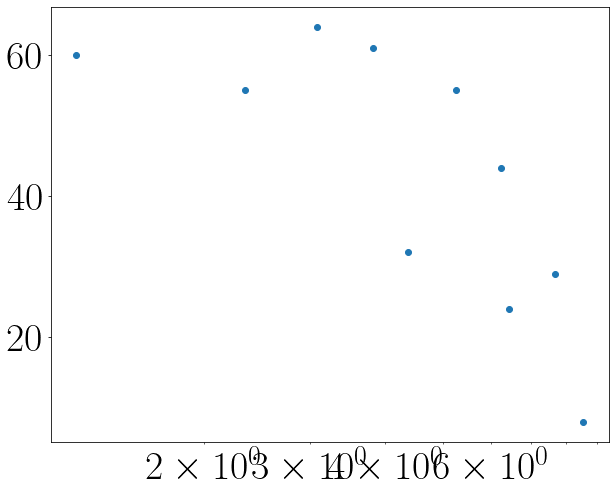

 25%|██▌       | 1/4 [00:05<00:15,  5.02s/it]

0.1 0.09 43.333333333333336 1 -0.01
128.44885000000002


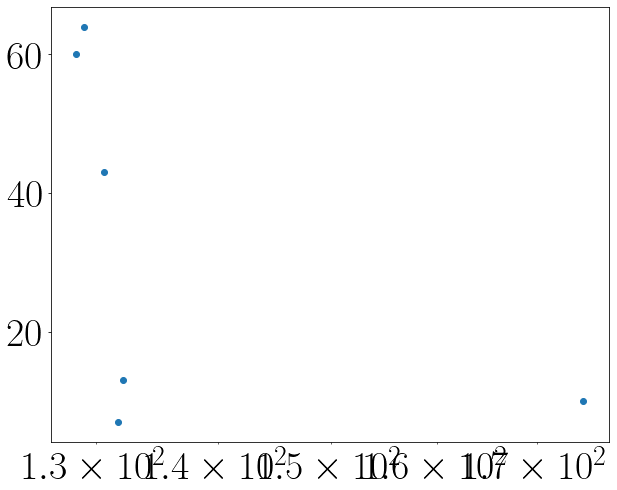

 50%|█████     | 2/4 [00:09<00:09,  4.98s/it]

10.0 0.09 85.66666666666667 1 -1.0
161.00768


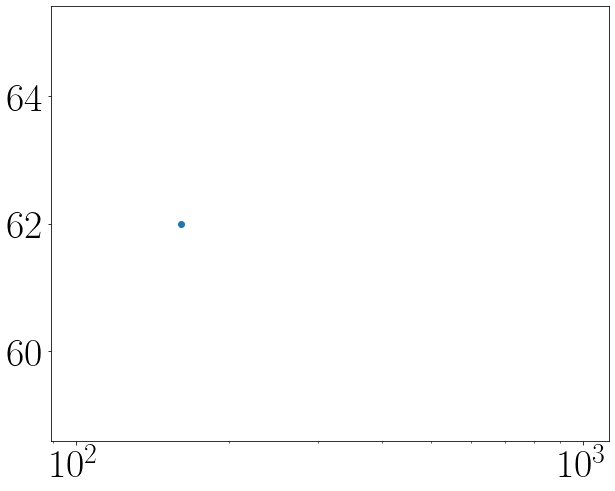

 75%|███████▌  | 3/4 [00:14<00:04,  4.89s/it]

32.0 0.09 128.0 1 -3.2
76.83001999999999


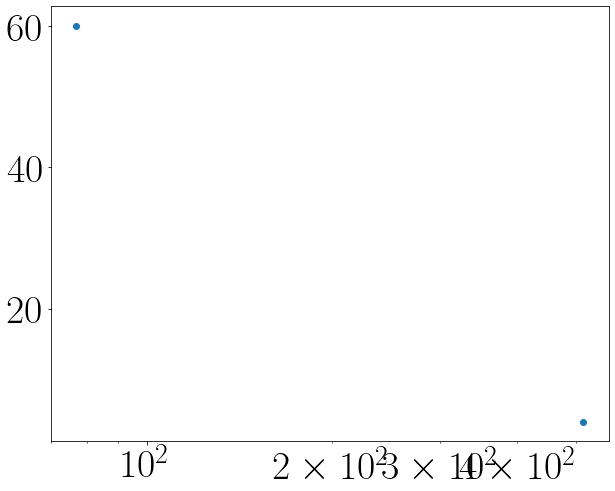

100%|██████████| 4/4 [00:19<00:00,  4.90s/it]


In [287]:
plt.rcParams.update({'font.size': 40})

def get_poles(args):
    (En,Xn), X0, Egs = args
    total_dim = len(Xn.dims[0])
    c_all = [tensor([sigmaz()]*(i) + [destroy(2)] + [identity(2)]*(total_dim - i -1)) for i in range(total_dim)]
    O1_up = sum([c_all[i] for i in range(2, total_dim-1, 2)])/(total_dim/2-1)
    O2_up = O1_up.dag()
    count = 0
    for Xgs in X0:
        C1_sq = np.real((Xgs.dag()*O1_up*Xn*Xn.dag()*O2_up*Xgs)[0][0][0])
        C2_sq = np.real((Xgs.dag()*O2_up*Xn*Xn.dag()*O1_up*Xgs)[0][0][0])
        if np.round(C1_sq, 5) > 0 or np.round(C1_sq, 5) > 0:
            count += 1
    return count, En - Egs
    
    

delta = 1
t=1
k_bath = 2*np.pi*np.linspace(0, Nk-1, Nk)/(a*Nk)
Ek_0 = np.round(-2*t*np.cos(k_bath*a), 2)
V = round(np.sqrt(delta/(np.pi * N0 * deltaE)), 2)
U_range = np.array([0, 0.1, 10, 32])*delta
J_range = np.linspace(1, 32*4, 4)*delta

for U,J in tqdm(zip(U_range, J_range), total=len(U_range)):
    print (U,V,J,t,-U/10)
    H = get_ham_K(Ek_0, -U/2, U, V, J, Ubath=-U/10)
    E, X = H.eigenstates()
    E = np.round(E, 5)
    X0 = X[np.where(E == min(E))]
    results = Pool().map(get_poles, product(zip(E, X), [X0], [min(E)]))
    poles = []
    counts = []
    for count,pole in results:
        if count == 0:
            continue
        if pole in poles:
            counts[poles.index(pole)] += count
        else:
            poles.append(pole)
            counts.append(count)
    print (min(poles))
    plt.scatter(poles, counts)
    plt.xscale("log")
    plt.show()